/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_85982/844886170.py:160: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_index = pd.date_range(startD, endD, freq="1S")
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_85982/844886170.py:163: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dh_full = dh_df.reindex(full_index).interpolate("time")


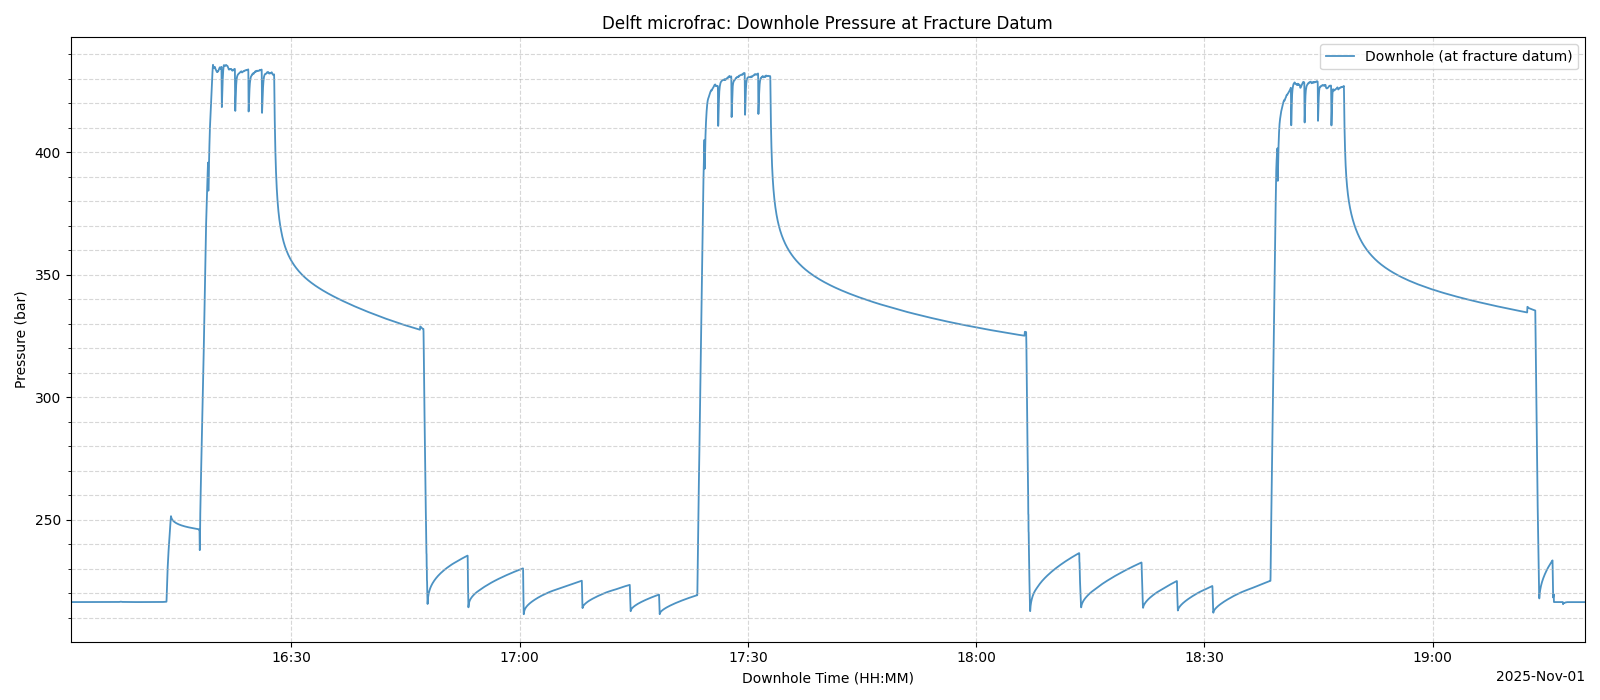

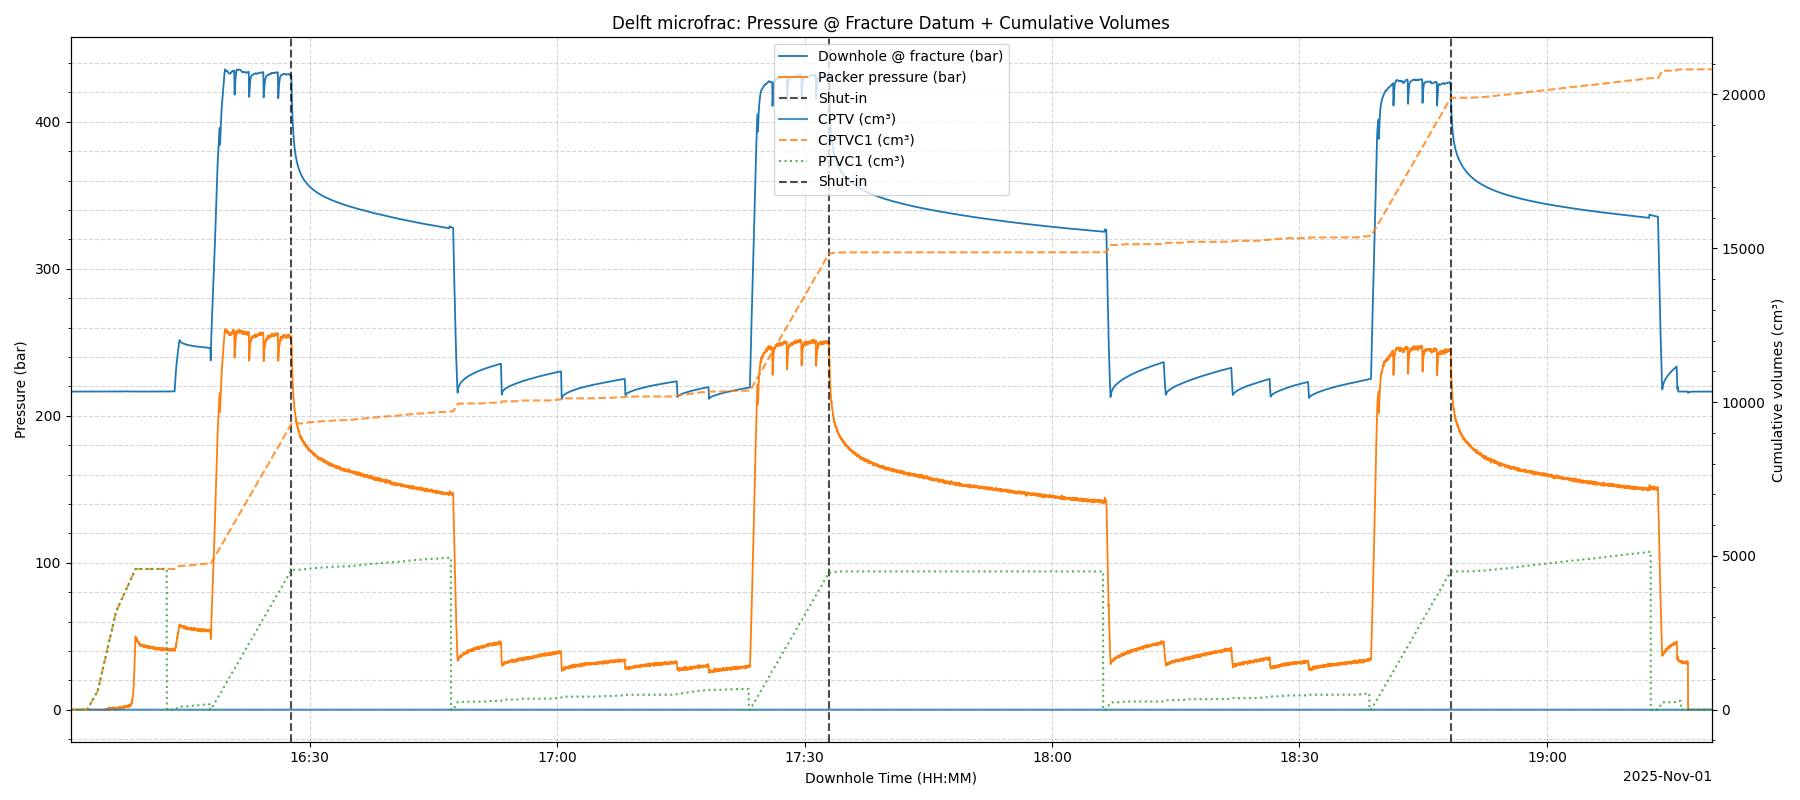

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
from pathlib import Path
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

from FCP_classes_2 import (
    HaimsonBilinearPicker,
    system_stiffness_pick,
    castillo_analyze_cycle_df,
    barree_pick,
)

from old_code import time_difference
from old_code import well_corrections

%matplotlib widget

# ------------------------------ Config ------------------------------
base = Path("Data")

# Delft microfrac downhole-only file
DOWNHOLE_FILE = base / "XLOT_minifrac/Delft/TU_DELFT_GT02_MICROFRAC_2506_7M_converted_simple.txt"

# Time window (downhole clock) — ADAPT THESE to the interval you want
startD = pd.to_datetime("2025-11-01 16:01:00")
endD   = pd.to_datetime("2025-11-01 19:20:00")


# Hydrostatic correction to FRACTURE datum (Config)
# (A) Geometry / sensor positions (replace with Delft-specific if needed)
MD = np.array([650.9, 659.25, 670.0], dtype=float)
TVD = np.array([650.89, np.nan, 669.98], dtype=float)  # NaN = missing value
TVD_fracture_m = 656.25
gauge_index    = 1
TVD_surface_sensor_m = -1.46   # surface transducer above TVD=0 by 1.46 m (not used here)

# (B) Use helper to get positions and ΔTVDs (down-positive)
TVD_interp, TVD_gauge_m, delta_tvd_gauge_to_frac_m = well_corrections.estimate_lag(
    MD, TVD, gauge_index, TVD_fracture_m
)

# (C) Unit constants
PSIA_TO_BAR = 1.0 / 14.5037738   # for SPEP (psi → bar), if you want it
RHO = 1.10 * 10**3               # kg/m^3  (single fluid density for Delft data)
G   = 9.80665                    # m/s^2
PA_TO_BAR = 1e-5

# ------------------------------ Utilities ------------------------------
def to_float_smart(s):
    if s is None:
        return None
    txt = str(s).strip().replace("\u00A0", " ").replace(",", ".")
    tokens = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if not tokens:
        return None
    for tok in tokens:
        if "." in tok:
            try:
                return float(tok)
            except ValueError:
                continue
    try:
        return float(tokens[0])
    except ValueError:
        return None

# ------------------------------ Parser for Delft downhole file ------------------------------
def parse_downhole_delft(path: Path) -> pd.DataFrame:
    """
    Parse TU_DELFT_GT02_MICROFRAC_converted_simple.txt

    Expected format per data line:
      DD-MM-YYYY HH:MM:SS  TIME  APQJ  CPTV  CPTVC1  PTVC1  RTDQJ  SPEP

    where:
      TIME   : system time since record start (s)
      APQJ   : gauge pressure (bar)
      CPTV   : cumulative pump-through volume (cm³)
      CPTVC1 : cumulative pump volume (cm³)
      PTVC1  : pump volume (cm³)
      RTDQJ  : gauge temperature (°C)
      SPEP   : packer element pressure (psi)
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue

            # Skip lines that do not start with a date
            if not re.match(r"\d{2}-\d{2}-\d{4}\s+\d{2}:\d{2}:\d{2}", ln):
                continue

            parts = re.split(r"\s+", ln)
            if len(parts) < 9:
                continue

            date_s = parts[0]
            time_s = parts[1]

            vals = [to_float_smart(p) for p in parts[2:9]]
            if any(v is None for v in vals):
                continue

            time_rel_s, apqj_bar, cptv_cm3, cptvc1_cm3, ptvc1_cm3, temp_degC, spep_psi = vals

            rows.append({
                "timestamp": f"{date_s} {time_s}",
                "TIME_s": time_rel_s,
                "APQJ_bar": apqj_bar,
                "CPTV_cm3": cptv_cm3,
                "CPTVC1_cm3": cptvc1_cm3,
                "PTVC1_cm3": ptvc1_cm3,
                "RTDQJ_degC": temp_degC,
                "SPEP_psi": spep_psi,
            })

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Downhole Delft: no data recognized.")

    df["time"] = pd.to_datetime(
        df["timestamp"],
        format="%d-%m-%Y %H:%M:%S",
        dayfirst=True,
        errors="coerce",
    )
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df

# ------------------------------ Load & prepare downhole data ------------------------------
dh_df = parse_downhole_delft(DOWNHOLE_FILE)

dh_df = dh_df[~dh_df.index.duplicated(keep="first")]

# Crop to analysis window
dh_df = dh_df.loc[startD:endD]


if dh_df.empty:
    raise RuntimeError("Downhole Delft: no data inside [startD, endD]. Adjust the window.")

# --- build a 1-second grid over the window ---
full_index = pd.date_range(startD, endD, freq="1S")

# Interpolate onto 1 s grid
dh_full = dh_df.reindex(full_index).interpolate("time")

# This is the main working dataframe
combined = dh_full.copy()

# ---- X axis as elapsed hours from startD (i.e., 0 at startD) ----
hours = (combined.index - combined.index[0]) / pd.Timedelta(hours=1)
total_hours = (endD - startD) / pd.Timedelta(hours=1)

# ----------------------------
# Hydrostatic correction to FRACTURE datum
# ----------------------------

# (A) Pressure series in bar (APQJ already in bar)
combined["pressure_bar"] = combined["APQJ_bar"]

# Pack pressure in bar (optional, if you ever want it)
combined["SPEP_bar"] = combined["SPEP_psi"] * PSIA_TO_BAR

combined["volume"] = combined["CPTVC1_cm3"] / 1e6  # cm³ → m³

# (B) Effective density (kg/m^3): constant RHO for this dataset
combined["density_eff"] = RHO

# (C) Hydrostatic head from gauge depth to fracture datum
dP_gauge_to_frac_bar = (
    combined["density_eff"] * G * delta_tvd_gauge_to_frac_m * PA_TO_BAR
)

# Downhole gauge -> fracture datum
combined["P_dh_at_frac_bar"] = combined["pressure_bar"] + dP_gauge_to_frac_bar

# ----------------------------
# Plot 1: Downhole pressure at fracture datum
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 7))

p_dh_frac = combined["P_dh_at_frac_bar"]
mask1 = p_dh_frac.notna()

ax.plot(combined.index[mask1], p_dh_frac[mask1],
        label="Downhole (at fracture datum)", linewidth=1.3, zorder=1, alpha=0.8)

ax.set_xlabel("Downhole Time (HH:MM)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Delft microfrac: Downhole Pressure at Fracture Datum")

xloc = mdates.AutoDateLocator()
xfmt = mdates.ConciseDateFormatter(xloc)
ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(xfmt)

ax.yaxis.set_major_locator(mticker.AutoLocator())
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax.grid(True, which="both", axis="both", linestyle="--", alpha=0.5)

ax.set_xlim(startD, endD)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2: Pressure @ fracture + cumulative volumes
# ----------------------------
fig, ax1 = plt.subplots(figsize=(18, 8))

# Downhole pressure at fracture datum
ax1.plot(
    combined.index,
    combined["P_dh_at_frac_bar"],
    label="Downhole @ fracture (bar)",
    linewidth=1.3,
)

# Packer pressure (converted from psi to bar)
ax1.plot(
    combined.index,
    combined["SPEP_bar"],
    label="Packer pressure (bar)",
    linewidth=1.3,
)

ax1.set_xlabel("Downhole Time (HH:MM)")
ax1.set_ylabel("Pressure (bar)")

xloc1 = mdates.AutoDateLocator()
xfmt1 = mdates.ConciseDateFormatter(xloc1)
ax1.xaxis.set_major_locator(xloc1)
ax1.xaxis.set_major_formatter(xfmt1)

ax1.yaxis.set_major_locator(mticker.AutoLocator())
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.5)

# Secondary axis: cumulative volumes (cm³)
ax2 = ax1.twinx()

if "CPTV_cm3" in combined.columns:
    ax2.plot(combined.index, combined["CPTV_cm3"],
             label="CPTV (cm³)", linestyle="-", alpha=0.8)
if "CPTVC1_cm3" in combined.columns:
    ax2.plot(combined.index, combined["CPTVC1_cm3"],
             label="CPTVC1 (cm³)", linestyle="--", alpha=0.8)
if "PTVC1_cm3" in combined.columns:
    ax2.plot(combined.index, combined["PTVC1_cm3"],
             label="PTVC1 (cm³)", linestyle=":", alpha=0.8)

ax2.set_ylabel("Cumulative volumes (cm³)")
ax2.yaxis.set_major_locator(mticker.AutoLocator())
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())

# Shut-in markers (if provided)
shutin_line = None
if USE_MANUAL_SHUTIN and MANUAL_SHUTINS_DH:
    first_label_added = False
    for ts in MANUAL_SHUTINS_DH:
        try:
            shut_dt = pd.to_datetime(ts)
            ln = ax1.axvline(shut_dt, color="k", linestyle="--", alpha=0.7,
                             label="Shut-in" if not first_label_added else None)
            if not first_label_added:
                shutin_line = ln
                first_label_added = True
        except Exception as e:
            print(f"Warning parsing shut-in: {e}")

ax1.set_xlim(startD, endD)

# Combine legends from both axes
lines, labels = [], []
for a in (ax1, ax2):
    ln, lb = a.get_legend_handles_labels()
    lines.extend(ln)
    labels.extend(lb)
if shutin_line is not None:
    lines.append(shutin_line)
    labels.append("Shut-in")

ax1.legend(lines, labels, loc="upper center")
plt.title("Delft microfrac: Pressure @ Fracture Datum + Cumulative Volumes")
plt.tight_layout()
plt.show()

In [200]:
CYCLES = [
    {
        "t_start": pd.Timestamp("2025-11-01 16:18:00"),
        "t_end":   pd.Timestamp("2025-11-01 16:46:45"),
    },
    {
        "t_start": pd.Timestamp("2025-11-01 17:23:22"),
        "t_end":   pd.Timestamp("2025-11-01 18:06:20"),
    },
    {
        "t_start": pd.Timestamp("2025-11-01 18:38:41"),
        "t_end":   pd.Timestamp("2025-11-01 19:12:00"),
    }
     
]

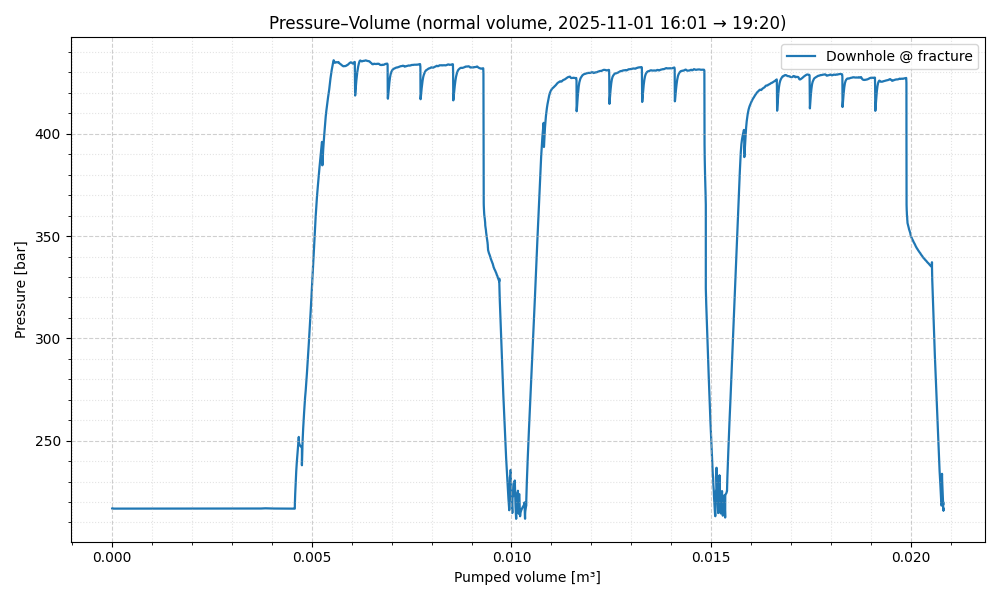

In [201]:
# ----------------------------
# Pressure vs Normal Volume (entire startD → endD window)
# ----------------------------
mask_window = (hours >= 0) & (hours <= total_hours)

V    = combined.loc[mask_window, "volume"]
P_dh = combined.loc[mask_window, "pressure_bar"]

df_pv = pd.DataFrame({"V": V, "P_dh": P_dh}).dropna()

figPV, axPV = plt.subplots(figsize=(10, 6))
axPV.plot(df_pv["V"], df_pv["P_dh"], label="Downhole @ fracture", lw=1.6, zorder=0)

axPV.set_xlabel("Pumped volume [m³]")
axPV.set_ylabel("Pressure [bar]")
axPV.set_title(
    f"Pressure–Volume (normal volume, {startD:%Y-%m-%d %H:%M} → {endD:%H:%M})"
)

# --- adaptive tick locators ---
axPV.xaxis.set_major_locator(mticker.AutoLocator())
axPV.xaxis.set_minor_locator(mticker.AutoMinorLocator())

axPV.yaxis.set_major_locator(mticker.AutoLocator())
axPV.yaxis.set_minor_locator(mticker.AutoMinorLocator())

# --- grid on both major & minor ticks ---
axPV.grid(True, which="major", linestyle="--", alpha=0.6)
axPV.grid(True, which="minor", linestyle=":", alpha=0.35)

axPV.legend(loc="best")

plt.tight_layout()
plt.show()

Defined 3 manual cycles.


start_idx  end_idx             t_start               t_end        duration  \
0       1020     2745 2025-11-01 16:18:00 2025-11-01 16:46:45 0 days 00:28:45   
1       4942     7520 2025-11-01 17:23:22 2025-11-01 18:06:20 0 days 00:42:58   
2       9461    11460 2025-11-01 18:38:41 2025-11-01 19:12:00 0 days 00:33:19   

   start_value  end_value  samples  
0     0.004754   0.009693     1726  
1     0.010372   0.014867     2579  
2     0.015400   0.020516     2000

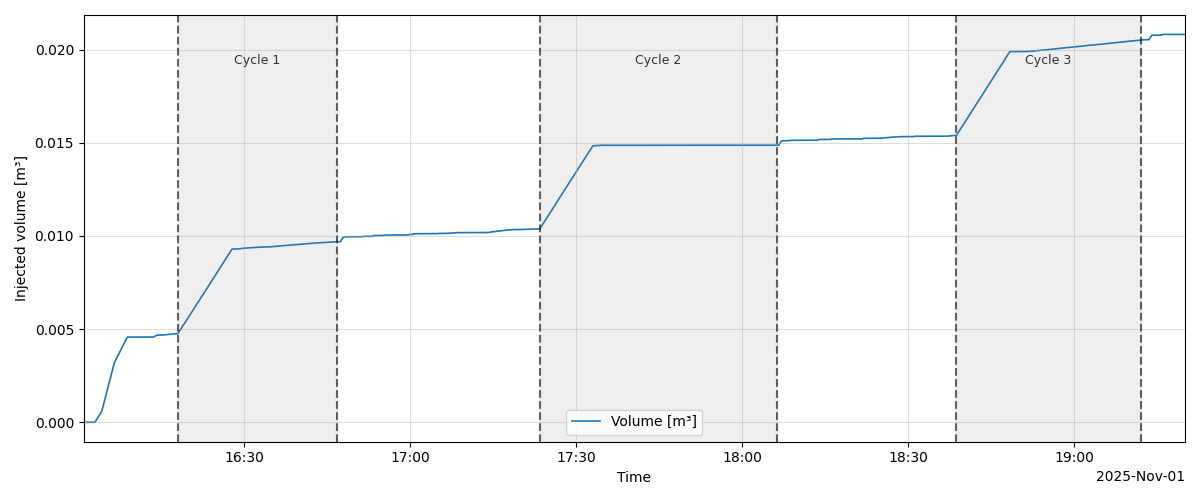

In [202]:
def build_cycles_df_from_manual(volume: pd.Series, cycles: list[dict]) -> pd.DataFrame:
    """
    Build a cycles_df from a manually defined list of cycles.

    cycles: list of dicts with keys:
        - "t_start": pd.Timestamp
        - "t_end":   pd.Timestamp
    """
    v = pd.Series(volume, copy=False).astype(float)
    idx = v.index

    rows = []
    for i, cyc in enumerate(cycles, start=1):
        t_start = pd.to_datetime(cyc["t_start"])
        t_end   = pd.to_datetime(cyc["t_end"])

        # skip nonsense
        if t_end <= t_start:
            continue

        # clip to available data range
        t_start_clipped = max(t_start, idx.min())
        t_end_clipped   = min(t_end, idx.max())

        # nearest indices in the volume series
        s_i = idx.get_indexer([t_start_clipped], method="nearest")[0]
        e_i = idx.get_indexer([t_end_clipped],   method="nearest")[0]
        if e_i < s_i:
            continue

        t_start_i = idx[s_i]
        t_end_i   = idx[e_i]
        duration  = t_end_i - t_start_i

        rows.append({
            "start_idx": int(s_i),
            "end_idx":   int(e_i),
            "t_start":   t_start_i,
            "t_end":     t_end_i,
            "duration":  duration,
            "start_value": float(v.iloc[s_i]) if np.isfinite(v.iloc[s_i]) else np.nan,
            "end_value":   float(v.iloc[e_i]) if np.isfinite(v.iloc[e_i]) else np.nan,
            "samples":   int(e_i - s_i + 1),
        })

    return pd.DataFrame(rows)

# restrict volume to your global window
vol_window = combined["volume"].loc[startD:endD]

cycles_df = build_cycles_df_from_manual(vol_window, CYCLES)
print(f"Defined {len(cycles_df)} manual cycles.")
display(cycles_df)



work = combined.loc[startD:endD]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(work.index, work["volume"], label="Volume [m³]", lw=1.2, zorder=1)

for i, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
    ax.axvline(cyc.t_start, color="k", ls="--", alpha=0.6)
    ax.axvline(cyc.t_end,   color="k", ls="--", alpha=0.6)
    ax.axvspan(cyc.t_start, cyc.t_end, color="grey", alpha=0.12)

    y_top = np.nanmax(work["volume"].values)
    t_mid = pd.to_datetime(cyc.t_start) + (pd.to_datetime(cyc.t_end) - pd.to_datetime(cyc.t_start)) / 2
    ax.text(
        t_mid,
        0.95 * y_top if np.isfinite(y_top) else 0.0,
        f"Cycle {i}",
        ha="center",
        va="top",
        fontsize=9,
        color="0.2",
    )

# adaptive x ticks (good for zooming)
xloc = mdates.AutoDateLocator()
xfmt = mdates.ConciseDateFormatter(xloc)
ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(xfmt)

ax.set_xlim(startD, endD)
ax.set_ylabel("Injected volume [m³]")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

Using 3 MANUAL cycles in window 2025-11-01 16:01:00 → 2025-11-01 19:20:00.


start_idx  end_idx             t_start               t_end        duration  \
0       1020     2745 2025-11-01 16:18:00 2025-11-01 16:46:45 0 days 00:28:45   
1       4942     7520 2025-11-01 17:23:22 2025-11-01 18:06:20 0 days 00:42:58   
2       9461    11460 2025-11-01 18:38:41 2025-11-01 19:12:00 0 days 00:33:19   

   start_value  end_value  samples  
0     0.004754   0.009693     1726  
1     0.010372   0.014867     2579  
2     0.015400   0.020516     2000

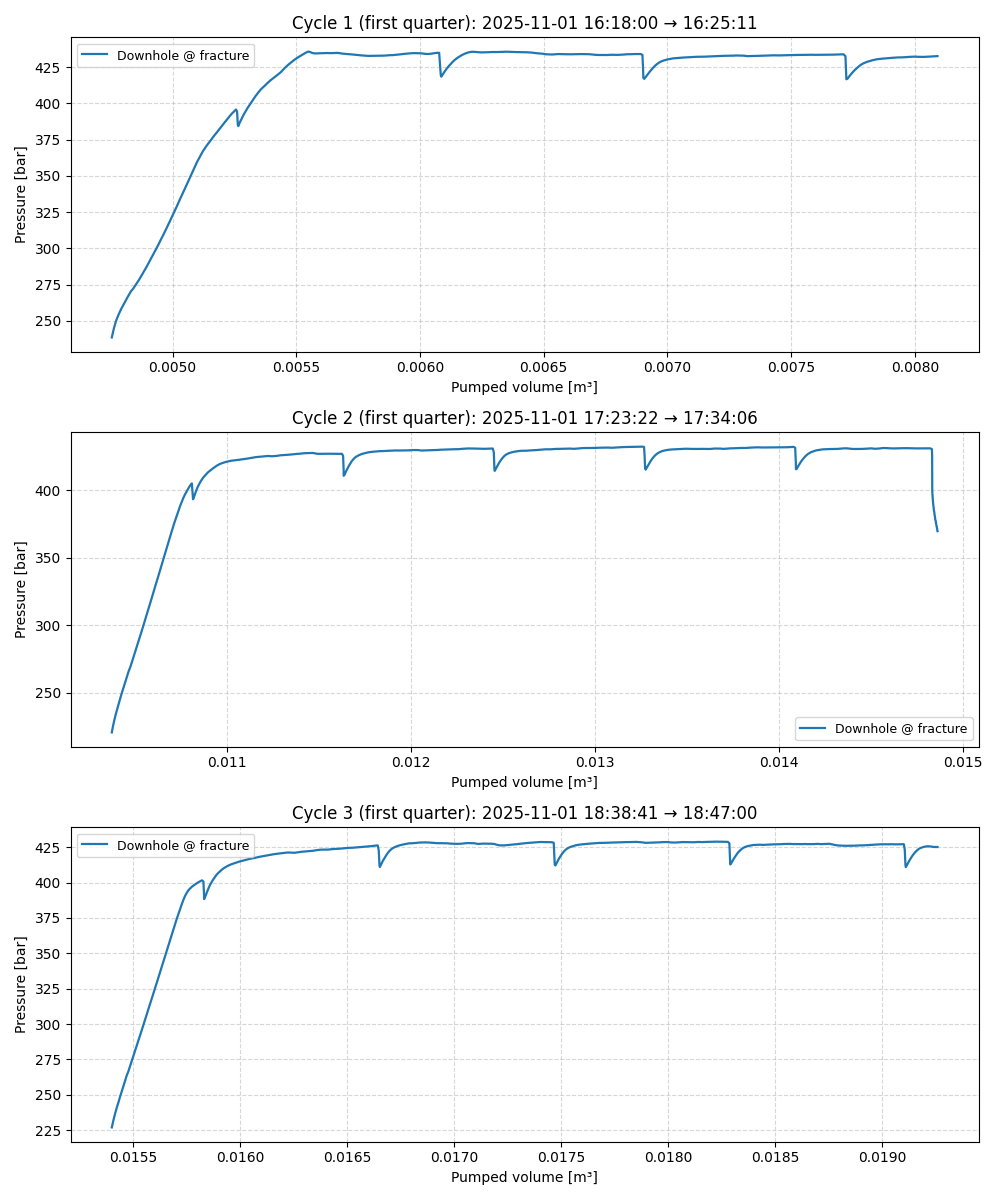

In [203]:
# ============================
# Plot Pressure vs Volume for each detected cycle (FIRST QUARTER by time)
# ============================

def build_cycles_df_from_manual(volume: pd.Series, cycles: list[dict]) -> pd.DataFrame:
    """
    Build a cycles_df from a manually defined list of cycles.

    cycles: list of dicts with keys:
        - "t_start": pd.Timestamp (or anything pd.to_datetime accepts)
        - "t_end":   pd.Timestamp (or anything pd.to_datetime accepts)
    """
    v = pd.Series(volume, copy=False).astype(float)
    idx = v.index

    rows = []
    for cyc in cycles:
        t_start = pd.to_datetime(cyc["t_start"])
        t_end   = pd.to_datetime(cyc["t_end"])

        if t_end <= t_start:
            continue

        # clip to available data range
        t_start_clipped = max(t_start, idx.min())
        t_end_clipped   = min(t_end, idx.max())

        # nearest indices in the volume series
        s_i = idx.get_indexer([t_start_clipped], method="nearest")[0]
        e_i = idx.get_indexer([t_end_clipped],   method="nearest")[0]
        if e_i < s_i:
            continue

        t_start_i = idx[s_i]
        t_end_i   = idx[e_i]
        duration  = t_end_i - t_start_i

        rows.append({
            "start_idx": int(s_i),
            "end_idx":   int(e_i),
            "t_start":   t_start_i,
            "t_end":     t_end_i,
            "duration":  duration,
            "start_value": float(v.iloc[s_i]) if np.isfinite(v.iloc[s_i]) else np.nan,
            "end_value":   float(v.iloc[e_i]) if np.isfinite(v.iloc[e_i]) else np.nan,
            "samples":   int(e_i - s_i + 1),
        })

    return pd.DataFrame(rows)


# 1) Build cycles_df from MANUAL cycles (no auto-detection)
vol_window = combined["volume"].loc[startD:endD]

cycles_df = build_cycles_df_from_manual(vol_window, CYCLES)
print(f"Using {len(cycles_df)} MANUAL cycles in window {startD} → {endD}.")
display(cycles_df)

# 2) Plot P–V for first quarter of each manual cycle
if len(cycles_df) == 0:
    print("No cycles to plot.")
else:
    work = combined.loc[startD:endD]
    n = len(cycles_df)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), squeeze=False)
    axes = axes.ravel()

    for k, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
        ax = axes[k-1]

        # --- First QUARTER by time based on manual cycle window ---
        t0 = pd.to_datetime(cyc.t_start)
        t1 = pd.to_datetime(cyc.t_end)
        if t1 <= t0:
            ax.text(0.5, 0.5, "Empty cycle", ha="center", va="center",
                    transform=ax.transAxes)
            ax.set_axis_off()
            continue

        t_quarter = t0 + (t1 - t0) / 4  # 25% of the manual cycle duration

        # Slice only the first quarter in time — ONLY downhole pressure
        df_cyc = work.loc[t0:t_quarter,
                          ["volume", "P_dh_at_frac_bar"]
                         ].dropna()

        if df_cyc.empty:
            ax.text(0.5, 0.5, "No data in first quarter", ha="center", va="center",
                    transform=ax.transAxes)
            ax.set_axis_off()
            continue

        # Plot P vs (instantaneous) volume for first quarter (downhole only)
        ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"],
                lw=1.6, label="Downhole @ fracture")

        ax.set_xlabel("Pumped volume [m³]")
        ax.set_ylabel("Pressure [bar]")
        ax.set_title(
            f"Cycle {k} (first quarter): "
            f"{t0:%Y-%m-%d %H:%M:%S} → {t_quarter:%H:%M:%S}"
        )

        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend(loc="best", fontsize=9)

    plt.tight_layout()
    plt.show()

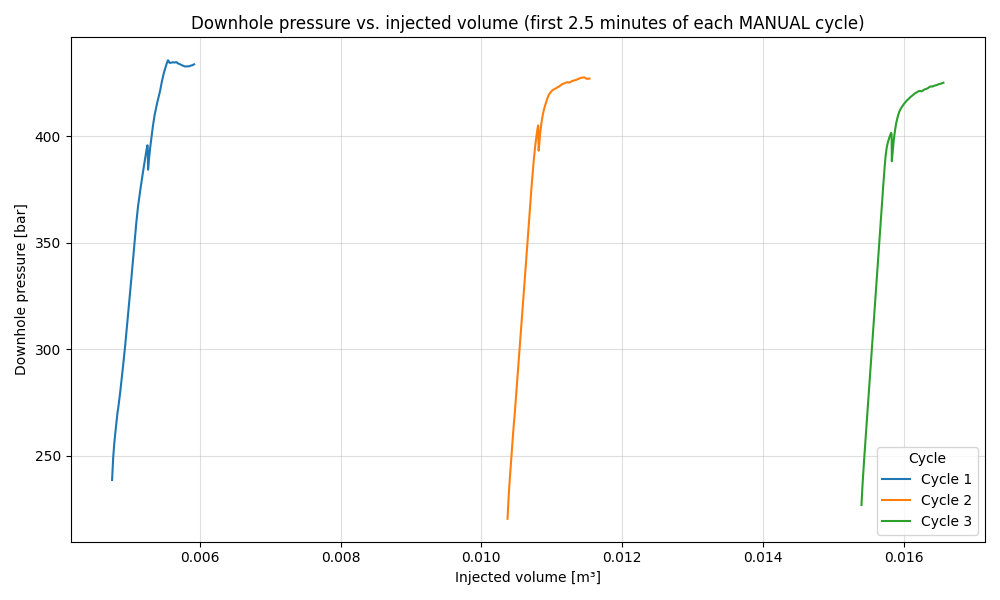

In [204]:
# =========================
# Plot P_dh vs Volume for ALL MANUAL cycles
# =========================

fig, ax = plt.subplots(figsize=(10, 6))

for i, cyc in enumerate(CYCLES, start=1):

    # Manual cycle start/end (surface/downhole time as you defined them)
    t_start = pd.to_datetime(cyc["t_start"])
    t_end   = pd.to_datetime(cyc["t_end"])

    # Plot only the first 2.5 minutes of each manual cycle
    t_end_plot = min(t_start + pd.Timedelta(minutes=2.5), t_end)

    # Slice downhole pressure + volume over [t_start, t_end_plot]
    segP = combined["P_dh_at_frac_bar"].loc[
        (combined.index >= t_start) &
        (combined.index <= t_end_plot)
    ]
    segV = combined["volume"].loc[
        (combined.index >= t_start) &
        (combined.index <= t_end_plot)
    ]

    if segP.empty or segV.empty:
        print(f"Cycle {i}: no usable data found in this window "
              f"({t_start} → {t_end_plot}).")
        continue

    # Plot Pressure vs Volume
    ax.plot(segV.values, segP.values, lw=1.5, label=f"Cycle {i}")

# --- Formatting ---
ax.set_xlabel("Injected volume [m³]")
ax.set_ylabel("Downhole pressure [bar]")
ax.set_title("Downhole pressure vs. injected volume "
             "(first 2.5 minutes of each MANUAL cycle)")
ax.grid(True, alpha=0.4)
ax.legend(title="Cycle")

plt.tight_layout()
plt.show()

Manual end-time selected: 2025-11-01 16:18:45

Compliance regression:
  Using: 2025-11-01 16:18:00 → 2025-11-01 16:18:45
  Slope a = 3.310358e+05 bar/m³
  Intercept b = -1.331179e+03
  R² = 0.9966
  → Compliance = 3.021e-06 m³/bar (0.003 L/bar)


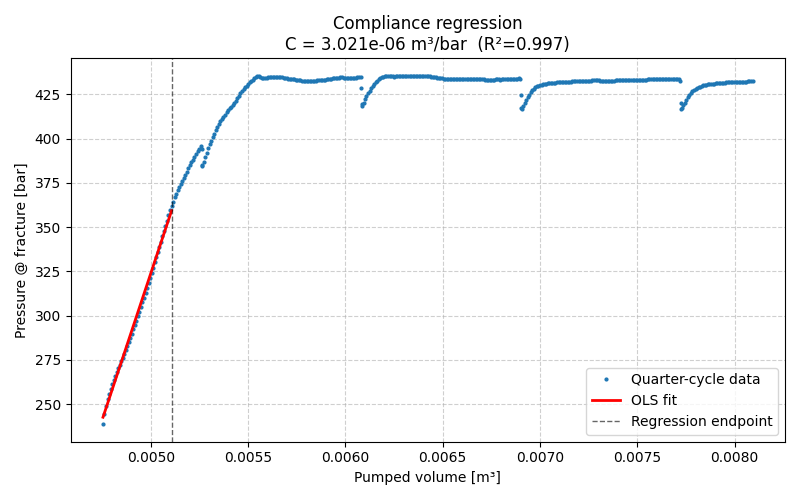

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ===========================================
# Compliance from first quarter of first MANUAL cycle (P vs V)
# WITH MANUAL END-POINT SELECTION
# ===========================================

# -------------------------------
# Manual pick settings
# -------------------------------
USE_MANUAL_PICK = True            # True = override max-pressure pick
PICK_METHOD = "time"             # "click" or "time"
MANUAL_END_TIME = "2025-11-01 16:18:45"   # only used if PICK_METHOD=="time"


# --- Select first manual cycle only ---
first_cyc = CYCLES[0]
t0 = pd.to_datetime(first_cyc["t_start"])
t1 = pd.to_datetime(first_cyc["t_end"])

# Optional: clip to data window if needed
t0 = max(t0, combined.index.min())
t1 = min(t1, combined.index.max())
if t1 <= t0:
    raise RuntimeError(f"Invalid first cycle window: {t0} → {t1}")

# First quarter in time of the manual cycle
t_quarter = t0 + (t1 - t0) / 4

# --- Subset to first quarter of first manual cycle ---
df_cyc = combined.loc[t0:t_quarter, ["volume", "P_dh_at_frac_bar"]].dropna()
if df_cyc.empty:
    raise RuntimeError("No valid data in first quarter of first manual cycle.")

# Default endpoint = automatic max pressure inside the quarter
imax_auto = df_cyc["P_dh_at_frac_bar"].idxmax()
end_time = imax_auto


# =======================================
# OPTION A — CLICK ON PLOT TO SET ENDPOINT
# =======================================
if USE_MANUAL_PICK and PICK_METHOD == "click":

    print("\n>>> Click the point up to which you want to perform the regression.")
    print(">>> Close the plot window after selecting.")

    fig_click, ax_click = plt.subplots(figsize=(8, 4))
    ax_click.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], 'o', ms=3)
    ax_click.set_title("Click desired end point for regression")
    ax_click.set_xlabel("Volume [m³]")
    ax_click.set_ylabel("Pressure [bar]")

    clicked = []

    def onclick(event):
        if event.xdata is None:
            return
        clicked.append((event.xdata, event.ydata))
        print(f"Clicked: volume={event.xdata:.4f}")

    cid = fig_click.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

    if len(clicked) == 0:
        print("No click detected → fallback to automatic max pressure.")
        end_time = imax_auto
    else:
        clicked_vol = clicked[-1][0]
        # Convert clicked volume to nearest timestamp in df_cyc
        idx = (df_cyc["volume"] - clicked_vol).abs().idxmin()
        end_time = idx
        print(f"Selected endpoint at time {end_time}")

# =======================================
# OPTION B — MANUAL TIMESTAMP ENTRY
# =======================================
elif USE_MANUAL_PICK and PICK_METHOD == "time":

    try:
        manual_dt = pd.to_datetime(MANUAL_END_TIME)
        # Clamp to valid range
        if manual_dt < df_cyc.index.min():
            manual_dt = df_cyc.index.min()
        if manual_dt > df_cyc.index.max():
            manual_dt = df_cyc.index.max()
        end_time = manual_dt
        print(f"Manual end-time selected: {end_time}")
    except Exception as e:
        print(f"Invalid MANUAL_END_TIME: {e} → fallback to auto pick.")
        end_time = imax_auto


# =================================================
# Build regression subset df_fit from t0 → end_time
# =================================================
df_fit = df_cyc.loc[:end_time]
if df_fit.empty:
    raise RuntimeError("Regression window is empty.")

# ========== Linear regression ==========
V = df_fit["volume"].values
P = df_fit["P_dh_at_frac_bar"].values
coeffs = np.polyfit(V, P, 1)
slope, intercept = coeffs  # slope = dP/dV
P_fit = np.poly1d(coeffs)

# ========== Compliance ==========
if slope != 0:
    C_m3_per_bar = 1.0 / slope
    C_L_per_bar  = C_m3_per_bar * 1e3
else:
    C_m3_per_bar = np.nan
    C_L_per_bar  = np.nan

# ========== R² ==========
residuals = P - P_fit(V)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((P - np.mean(P))**2)
r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

# ========== Print report ==========
print(f"\nCompliance regression:")
print(f"  Using: {t0} → {end_time}")
print(f"  Slope a = {slope:.6e} bar/m³")
print(f"  Intercept b = {intercept:.6e}")
print(f"  R² = {r2:.4f}")
print(f"  → Compliance = {C_m3_per_bar:.3e} m³/bar ({C_L_per_bar:.3f} L/bar)")

# ========== Final plot ==========
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], 'o', ms=2, label="Quarter-cycle data")
ax.plot(df_fit["volume"], P_fit(df_fit["volume"]), 'r-', lw=2, label="OLS fit")
ax.axvline(df_fit["volume"].iloc[-1], color='k', ls='--', lw=1, alpha=0.6, label="Regression endpoint")

ax.set_xlabel("Pumped volume [m³]")
ax.set_ylabel("Pressure @ fracture [bar]")
ax.set_title(f"Compliance regression\nC = {C_m3_per_bar:.3e} m³/bar  (R²={r2:.3f})")
ax.grid(True, ls='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_85982/1105606674.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work["V_m3"] = work[V_col] * 1e-6  # cm³ → m³
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_85982/1105606674.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work["q_pump_m3h_raw"] = q_m3_s_raw * 3600.0
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_85982/1105606674.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

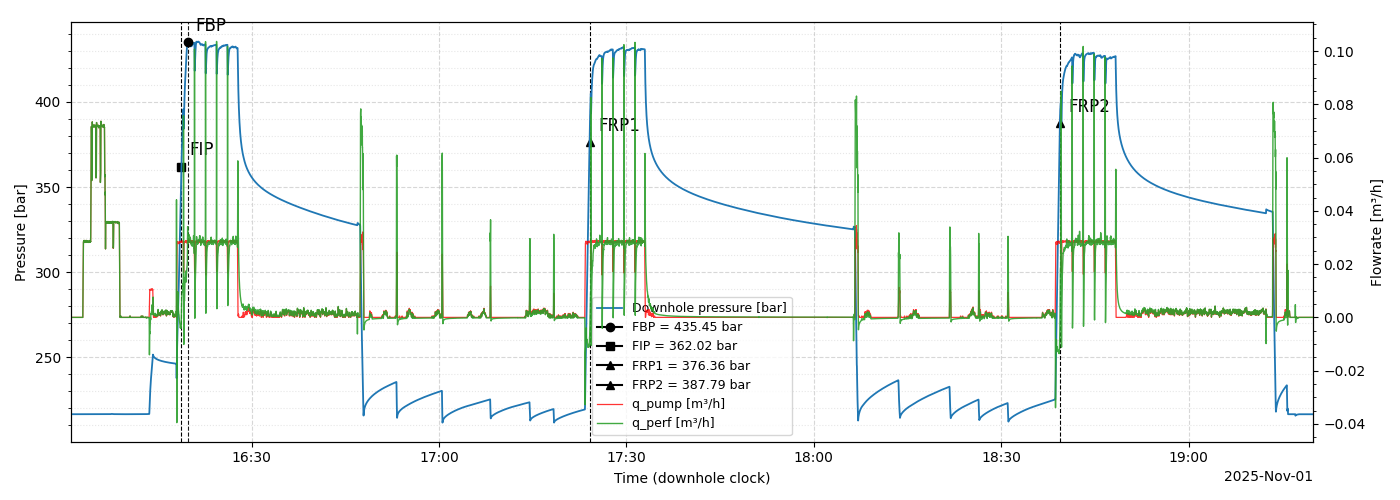

In [206]:
# ============================
# FIP / FBP / FRP overlay with q_pump, q_perf, and P_dh (downhole clock)
# ============================

import matplotlib.dates as mdates

# ---- Inputs (set these) ----
C_WELL = C_m3_per_bar  # m³/bar  (system/wellbore compliance used for q_perf calculation)



# Optional manual picks on the DOWNHOLE clock:
FIP_TIME    = pd.Timestamp("2025-11-01 16:18:45")
FRP_TIME_1  = pd.Timestamp("2025-11-01 17:24:06")
FRP_TIME_2  = pd.Timestamp("2025-11-01 18:39:24")

FRP_TIMES = [FRP_TIME_1, FRP_TIME_2]

# ---- NEW: manual FBP option ----
USE_MANUAL_FBP = True  # set to True to override automatic FBP
MANUAL_FBP_TIME = pd.Timestamp("2025-11-01 16:19:44")  # example; edit as needed

# ---- Pull series (window-aware) ----
work = combined.loc[startD:endD]


# ============================================================
# NEW: derive pump flowrate q_pump_m3h from cumulative volume
# ============================================================

V_col = "CPTVC1_cm3"             # Delft cumulative pump volume
work["V_m3"] = work[V_col] * 1e-6  # cm³ → m³

dt_s = work.index.to_series().diff().dt.total_seconds()
dV_m3 = work["V_m3"].diff()

# avoid division by zero
q_m3_s_raw = dV_m3 / dt_s
q_m3_s_raw[dt_s <= 0] = np.nan

# convert to m³/h
work["q_pump_m3h_raw"] = q_m3_s_raw * 3600.0

# smooth the rate (recommended)
work["q_pump_m3h"] = (
    work["q_pump_m3h_raw"]
    .rolling(5, center=True, min_periods=1)
    .mean()
)


# ---- Downhole pressure [bar] ----
P_dh = (
    work["P_dh_at_frac_bar"]
    .astype(float)
    .sort_index()
)
P_dh = P_dh[~P_dh.index.duplicated(keep="first")].interpolate(
    "time", limit_direction="both"
)


# ---- dP/dt in bar/s ----
ts = (P_dh.index - P_dh.index[0]).total_seconds().to_numpy()
dPdt = np.gradient(P_dh.to_numpy(), ts)


# ============================================================
# NEW: q_perf from derived q_pump
# ============================================================
q_pump_m3h = work["q_pump_m3h"].to_numpy()      # m³/h
q_perf_m3h = (q_pump_m3h / 3600.0 - C_WELL * dPdt) * 3600.0   # m³/h


# ---- Helper: robust time interpolation on DH-indexed series ----
def _interp_time(series_dt: pd.Series, t_query: pd.Timestamp):
    s = series_dt.sort_index()
    s = s[~s.index.duplicated(keep="first")].interpolate(
        method="time", limit_direction="both"
    )
    t_min, t_max = s.index.min(), s.index.max()
    tq = min(max(pd.Timestamp(t_query), t_min), t_max)
    val = s.reindex(s.index.union([tq])).interpolate(method="time").loc[tq]
    return tq, float(val)


# ---- Picks ----

# --- FBP: manual option or automatic in first cycle ---

if USE_MANUAL_FBP and (MANUAL_FBP_TIME is not None):
    # Manual FBP: interpolate pressure at the given timestamp
    t_FBP, FBP_bar = _interp_time(P_dh, pd.Timestamp(MANUAL_FBP_TIME))
else:
    # Automatic FBP restricted to FIRST cycle from CYCLES
    cycle1_start = CYCLES[0]["t_start"]
    cycle1_end   = CYCLES[0]["t_end"]

    # Clamp the cycle window to the actual P_dh data range (defensive)
    t_min, t_max = P_dh.index.min(), P_dh.index.max()
    cycle1_start = max(cycle1_start, t_min)
    cycle1_end   = min(cycle1_end,   t_max)

    P_dh_cycle1 = P_dh.loc[cycle1_start:cycle1_end]

    if not P_dh_cycle1.empty:
        # FBP from first cycle ONLY
        t_FBP = P_dh_cycle1.idxmax()
    else:
        # Fallback: if window is empty for some reason, use global max
        t_FBP = P_dh.idxmax()

    FBP_bar = float(P_dh.loc[t_FBP])

# FIP
FIP_info = None
if FIP_TIME is not None:
    t_FIP_q, P_FIP = _interp_time(P_dh, pd.Timestamp(FIP_TIME))
    FIP_info = (t_FIP_q, P_FIP)

# FRPs
FRP_infos = []
for t_FRP in FRP_TIMES:
    if t_FRP is None:
        continue
    t_FRP_q, P_FRP = _interp_time(P_dh, pd.Timestamp(t_FRP))
    FRP_infos.append((t_FRP_q, P_FRP))


# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(14, 5))

t_dh = P_dh.index

# Pressure on primary axis
ax1.plot(t_dh, P_dh, color="C0", lw=1.3, zorder=3,
         label="Downhole pressure [bar]")

ax1.set_xlabel("Time (downhole clock)")
ax1.set_ylabel("Pressure [bar]")

xloc = mdates.AutoDateLocator()
xfmt = mdates.ConciseDateFormatter(xloc)
ax1.xaxis.set_major_locator(xloc)
ax1.xaxis.set_major_formatter(xfmt)

ax1.yaxis.set_major_locator(mticker.AutoLocator())
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)
ax1.grid(True, which="minor", axis="both", linestyle=":",  alpha=0.3)


# Secondary axis for TRUE flowrates (derived)
ax2 = ax1.twinx()

ax2.plot(
    work.index,
    work["q_pump_m3h"],
    color="red",
    lw=0.9,
    alpha=0.8,
    zorder=1,
    label="q_pump [m³/h]"
)

ax2.plot(
    work.index,
    q_perf_m3h,
    color="C2",
    lw=1.0,
    alpha=0.9,
    zorder=2,
    label="q_perf [m³/h]"
)

ax2.set_ylabel("Flowrate [m³/h]")
ax2.yaxis.set_major_locator(mticker.AutoLocator())
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())


# ========= Vertical lines & markers =========

# FBP
ax1.axvline(t_FBP, color="black", linestyle="--", lw=0.8, alpha=0.9)
ax1.plot(t_FBP, FBP_bar, marker="o", ms=6, color="black", zorder=5,
         label=f"FBP = {FBP_bar:.2f} bar")
ax1.annotate("FBP", xy=(t_FBP, FBP_bar), xytext=(6, 8),
             textcoords="offset points", color="black", fontsize=12)

# FIP
if FIP_info is not None:
    t_FIP_q, P_FIP = FIP_info
    ax1.axvline(t_FIP_q, color="black", linestyle="--", lw=0.8)
    ax1.plot(t_FIP_q, P_FIP, marker="s", ms=6, color="black",
             label=f"FIP = {P_FIP:.2f} bar")
    ax1.annotate("FIP", xy=(t_FIP_q, P_FIP), xytext=(6, 8),
                 textcoords="offset points", color="black", fontsize=12)

# FRPs
for j, (t_FRP_q, P_FRP) in enumerate(FRP_infos, start=1):
    ax1.axvline(t_FRP_q, color="black", linestyle="--", lw=0.8)
    ax1.plot(t_FRP_q, P_FRP, marker="^", ms=6, color="black",
             label=f"FRP{j} = {P_FRP:.2f} bar")
    ax1.annotate(f"FRP{j}", xy=(t_FRP_q, P_FRP), xytext=(6, 8),
                 textcoords="offset points", color="black", fontsize=12)


# ---- Legend ----
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="best", fontsize=9)

ax1.set_xlim(startD, endD)
plt.tight_layout()
plt.show()

# Falloff Analysis

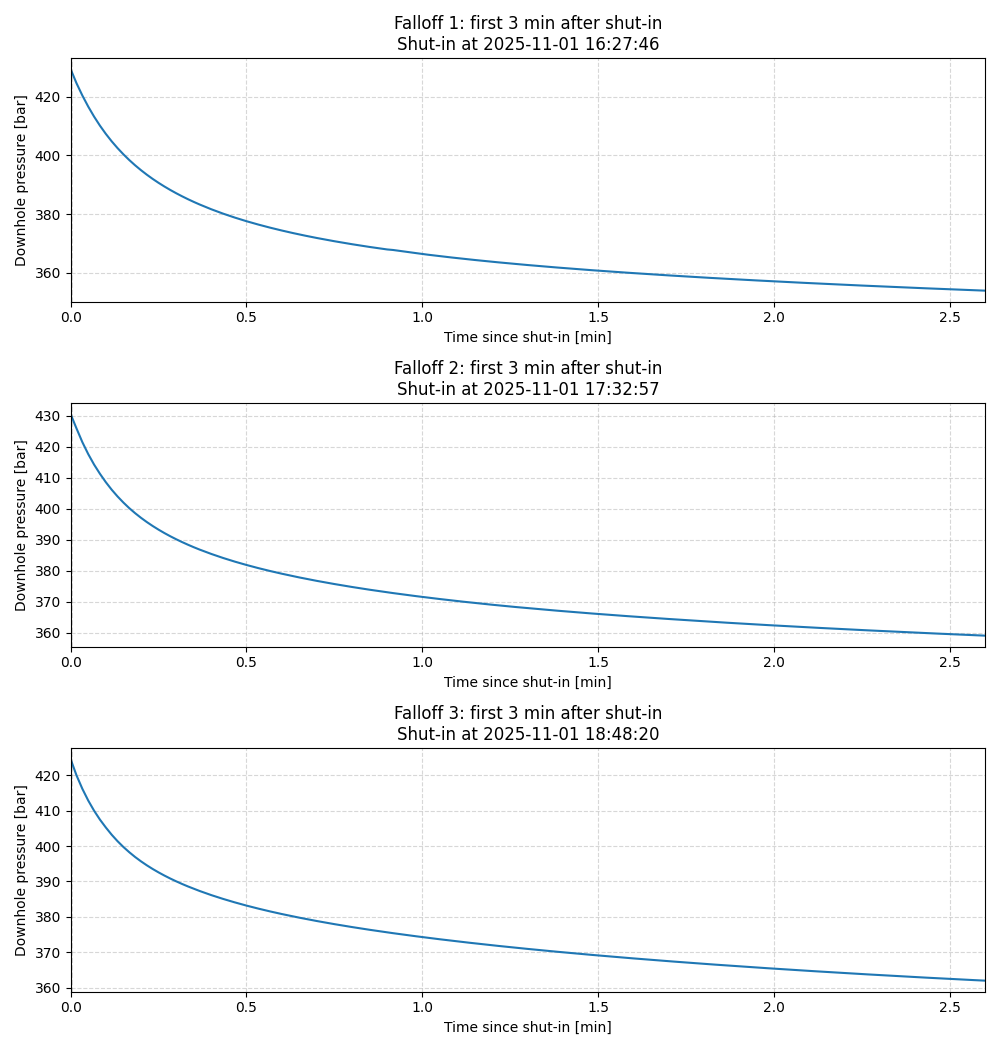

In [207]:
# ============================
# Settings
# ============================

# Duration of falloff window
FALLOFF_WINDOW = pd.Timedelta(minutes=2.6)

# Shut-in times on the DOWNHOLE clock, defined as the start of this notebook

# ============================
# Plot falloffs: one subplot per shut-in
# ============================

P_series = combined["P_dh_at_frac_bar"].astype(float)  # downhole @ fracture, bar
P_series = P_series.sort_index()

n = len(MANUAL_SHUTINS_DH)
if n == 0:
    print("No shut-in times defined – nothing to plot.")
else:
    fig, axes = plt.subplots(n, 1, figsize=(10, 3.5*n), squeeze=False)
    axes = axes.ravel()

    for i, (ax, t_si) in enumerate(zip(axes, MANUAL_SHUTINS_DH), start=1):
        t_si = pd.to_datetime(t_si)

        # Window: [shut-in, shut-in + 3 min]
        t_start = t_si
        t_end   = t_si + FALLOFF_WINDOW

        # Slice pressure series in that window
        p_seg = P_series.loc[(P_series.index >= t_start) & (P_series.index <= t_end)].dropna()

        if p_seg.empty:
            ax.text(0.5, 0.5,
                    f"No data in 0–3 min after shut-in {i}",
                    ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue

        # Time axis as minutes since shut-in
        t_rel_min = (p_seg.index - t_start) / pd.Timedelta(minutes=1)

        # Plot
        ax.plot(t_rel_min, p_seg, lw=1.5, color="tab:blue")
        ax.axvline(0.0, color="k", ls="--", lw=1.0, alpha=0.7)

        # Labels & title
        ax.set_xlabel("Time since shut-in [min]")
        ax.set_ylabel("Downhole pressure [bar]")
        ax.set_title(
            f"Falloff {i}: first 3 min after shut-in\n"
            f"Shut-in at {t_start:%Y-%m-%d %H:%M:%S}"
        )
        ax.grid(True, which="both", linestyle="--", alpha=0.5)

        # Optional: tighten x-limits exactly to [0, 3]
        ax.set_xlim(0, FALLOFF_WINDOW / pd.Timedelta(minutes=1))

    plt.tight_layout()
    plt.show()

In [208]:
def g_nolte_delta_tD(delta_t_since_shutin_s, t_p_seconds, alpha=0.5):
    """
    Nolte / Carter g-function g(Δt) for leakoff, where:

        Δt = t - t_shutin   (time since shut-in, in seconds)
        t_p = injection time (pumping duration from start of injection into fracture
                              until shut-in), in seconds

    Dimensionless variable:
        u = Δt / t_p  >= 0

    For α = 1/2 (Carter-type leakoff with constant-height fracture), the "most common"
    form (Gulrajani & Nolte, 2001) is:

        g(Δt) = 4/3 * [ (1 + u)^(3/2) - u^(3/2) ],   u = Δt / t_p

    We also include an upper bound for α = 1 (different growth assumption), and for
    0.5 < α < 1 we linearly interpolate between the two shapes:

        g_lower(u) = 4/3 * [ (1 + u)^(3/2) - u^(3/2) ]
        g_upper(u) = (1 + u) * arcsin( (1 + u)^(-1/2) ) + u^(1/2)

    Parameters
    ----------
    delta_t_since_shutin_s : array-like
        Time since shut-in Δt (seconds). Δt = 0 at shut-in.
    t_p_seconds : float
        Injection time t_p (seconds) for that cycle.
    alpha : float in [0.5, 1]
        Shape parameter (0.5 = lower bound, 1 = upper bound, interpolate in between).

    Returns
    -------
    g : np.ndarray
        Dimensionless g-function values g(Δt) at the given Δt / t_p.
    """
    import numpy as np

    delta_t_since_shutin_s = np.asarray(delta_t_since_shutin_s, dtype=float)
    t_p_seconds = float(t_p_seconds)
    if t_p_seconds <= 0:
        raise ValueError("t_p_seconds must be positive (injection duration).")

    # u = Δt / t_p  (dimensionless time since shut-in)
    u = np.clip(delta_t_since_shutin_s / t_p_seconds, 0.0, None)

    # Lower bound α = 1/2
    g_lower = (4.0 / 3.0) * ((1.0 + u)**1.5 - u**1.5)

    # Upper bound α = 1
    with np.errstate(invalid="ignore"):
        g_upper = (1.0 + u) * np.arcsin(1.0 / np.sqrt(1.0 + u)) + np.sqrt(u)

    alpha_clamped = min(max(alpha, 0.5), 1.0)
    if np.isclose(alpha_clamped, 0.5):
        return g_lower
    if np.isclose(alpha_clamped, 1.0):
        return g_upper

    w = (alpha_clamped - 0.5) / 0.5   # 0 at 0.5, 1 at 1
    return g_lower + w * (g_upper - g_lower)

Injection durations per cycle (downhole clock):


cycle             t_start              t_shut        duration  duration_s
0      1 2025-11-01 16:18:45 2025-11-01 16:27:46 0 days 00:09:01       541.0
1      2 2025-11-01 17:24:06 2025-11-01 17:32:57 0 days 00:08:51       531.0
2      3 2025-11-01 18:39:24 2025-11-01 18:48:20 0 days 00:08:56       536.0

Built inj_cycles for 3 cycles from inj_cycles_df.

Cycle 1:
                     delta_t_s        tD         g         G  P_dh_at_frac_bar
2025-11-01 16:27:46        0.0  0.000000  1.333333  0.000000        429.317931
2025-11-01 16:27:47        1.0  0.001848  1.336926  0.004574        424.534931
2025-11-01 16:27:48        2.0  0.003697  1.340434  0.009041        420.355931
2025-11-01 16:27:49        3.0  0.005545  1.343889  0.013439        416.587931
2025-11-01 16:27:50        4.0  0.007394  1.347300  0.017783        413.176931

Cycle 2:
                     delta_t_s        tD         g         G  P_dh_at_frac_bar
2025-11-01 17:32:57        0.0  0.000000  1.333333  0.000000        430.456931
2025-11-01 17:32:58        1.0  0.001883  1.336993  0.004659        425.860931
2025-11-01 17:32:59        2.0  0.003766  1.340565  0.009208        421.434931
2025-11-01 17:33:00        3.0  0.005650  1.344083  0.013686        417.594931
2025-11-01 17:33:01        4.0  0.007533  1.347556  0.018109 

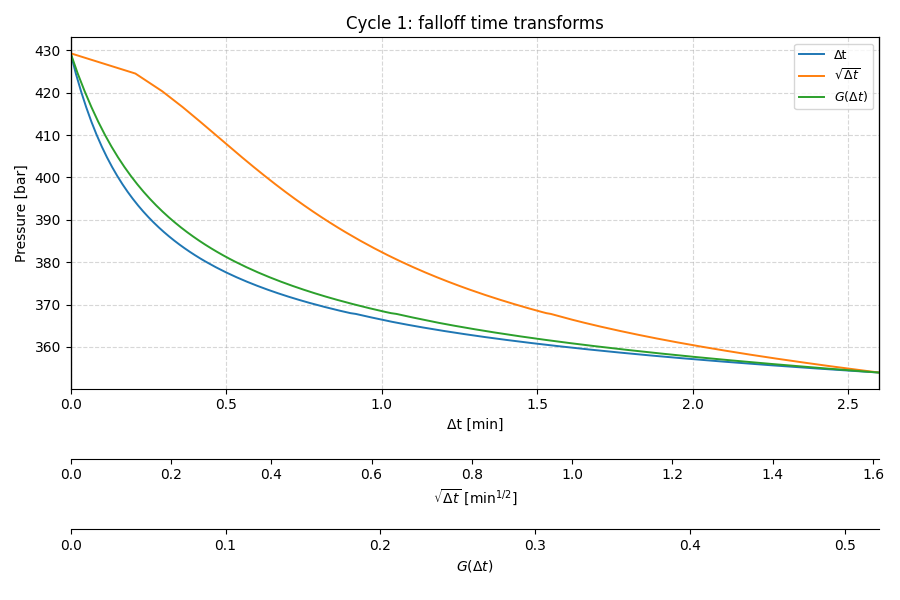

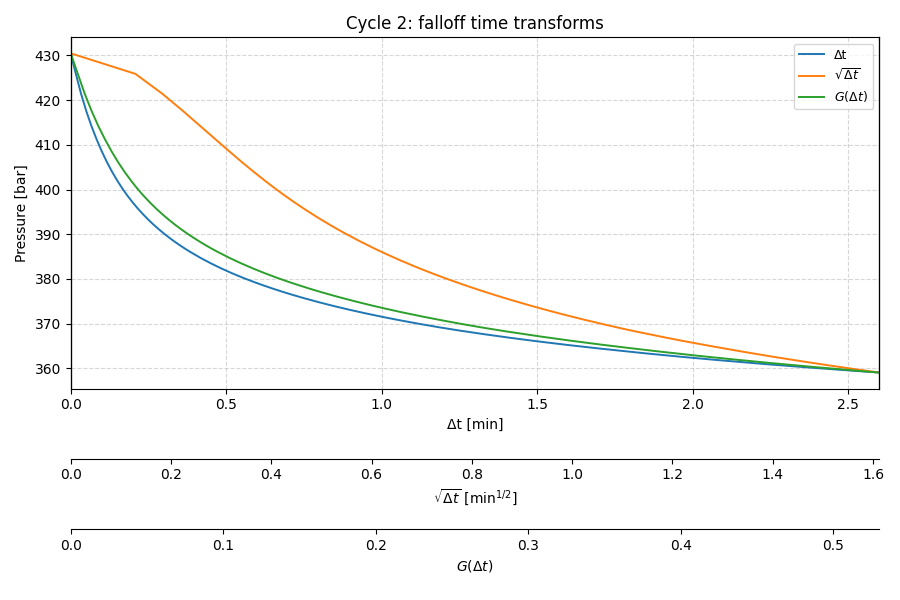

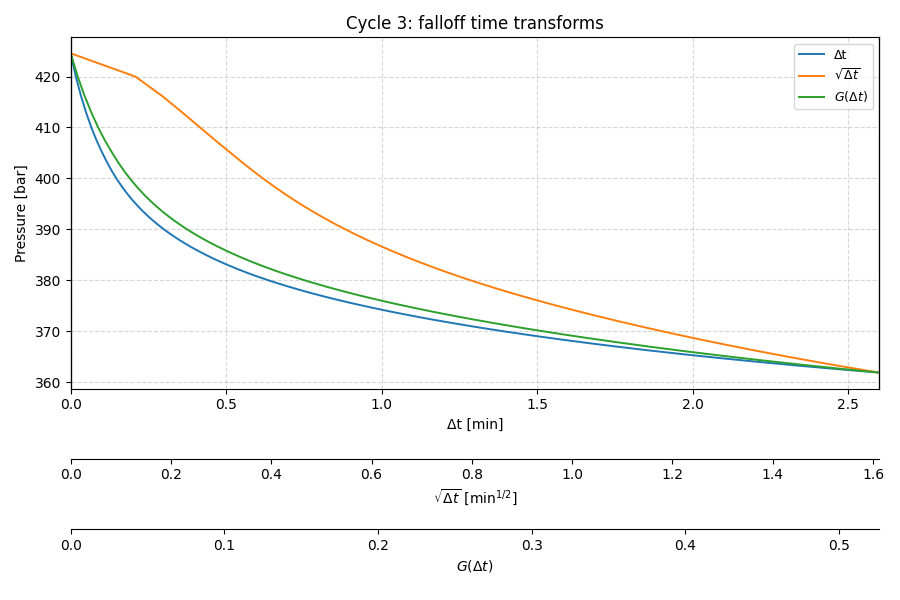

In [209]:
# -------------------------------------------
# 1) Injection durations per cycle (downhole clock)
# -------------------------------------------

# Start picks on DH clock (must already be defined)
cycle_start_times = [
    FIP_TIME,      # Cycle 1 starts at FIP
    FRP_TIME_1,    # Cycle 2 starts at first FRP
    FRP_TIME_2
]

rows = []
for i, (t_start, t_shut) in enumerate(zip(cycle_start_times, MANUAL_SHUTINS_DH), start=1):
    if t_start is None or t_shut is None:
        print(f"Cycle {i}: missing start or shut-in time, skipping.")
        continue

    t_start = pd.to_datetime(t_start)
    t_shut  = pd.to_datetime(t_shut)

    if t_shut <= t_start:
        print(f"Cycle {i}: shut-in time ≤ start time, skipping.")
        continue

    duration   = t_shut - t_start
    duration_s = duration.total_seconds()

    rows.append({
        "cycle":      i,
        "t_start":    t_start,
        "t_shut":     t_shut,
        "duration":   duration,
        "duration_s": duration_s,
    })

inj_cycles_df = pd.DataFrame(rows, columns=["cycle", "t_start", "t_shut", "duration", "duration_s"])

print("Injection durations per cycle (downhole clock):")
display(inj_cycles_df)

# -------------------------------------------
# 2) Build inj_cycles dict from inj_cycles_df
# -------------------------------------------

inj_cycles = {}  # cycle_index -> dict with times & tp

for row in inj_cycles_df.itertuples(index=False):
    cyc_id     = int(row.cycle)
    t_start    = pd.to_datetime(row.t_start)
    t_shut     = pd.to_datetime(row.t_shut)
    duration_s = float(row.duration_s)

    if duration_s <= 0:
        print(f"Cycle {cyc_id}: non-positive duration in inj_cycles_df, skipping.")
        continue
    if t_shut <= t_start:
        print(f"Cycle {cyc_id}: t_shut <= t_start in inj_cycles_df, skipping.")
        continue

    inj_cycles[cyc_id] = {
        "t_inj_start":  t_start,                   # start of injection into fracture
        "t_shut":       t_shut,                    # shut-in time
        "t_p_seconds":  duration_s,                # injection duration t_p
        "t_fall_start": t_shut,                    # falloff starts at shut-in
        "t_fall_end":   t_shut + timedelta(minutes=2.6),  # first 3 minutes of falloff
    }

print(f"Built inj_cycles for {len(inj_cycles)} cycles from inj_cycles_df.")

# -------------------------------------------
# 3) Compute g(Δt), G(Δt) for each cycle → G_cycles
# -------------------------------------------

ALPHA_G = 0.5  # Carter lower bound; you can change to 1.0 or interpolate

G_cycles = {}   # cycle_index -> DataFrame with Δt, tD, g, G, P

P_dh_full = combined["P_dh_at_frac_bar"].astype(float)

for cyc_id, info in inj_cycles.items():
    t_shut      = info["t_shut"]
    t_fall_start = info["t_fall_start"]
    t_fall_end   = info["t_fall_end"]
    t_p_seconds  = info["t_p_seconds"]   # injection duration t_p

    # Segment of falloff data
    seg = P_dh_full.loc[t_fall_start:t_fall_end].dropna()
    if seg.empty:
        print(f"Cycle {cyc_id}: no data in falloff window {t_fall_start} → {t_fall_end}.")
        continue

    df = seg.to_frame(name="P_dh_at_frac_bar")

    # Δt = time since shut-in, in seconds
    delta_t_s = (df.index - t_shut).total_seconds()
    df["delta_t_s"] = delta_t_s
    df["tD"]        = delta_t_s / t_p_seconds   # dimensionless Δt/t_p

    # g(Δt) from Nolte/Carter
    g_vals = g_nolte_delta_tD(delta_t_s, t_p_seconds, alpha=ALPHA_G)
    df["g"] = g_vals

    # g(0) is g at Δt=0 → first sample at/after shut-in
    g0 = float(g_vals[0])

    # G(Δt) = 4/π [g(Δt) - g(0)]
    G_vals = (4.0 / np.pi) * (g_vals - g0)
    df["G"] = G_vals

    G_cycles[cyc_id] = df

# Quick check print
for cyc_id in sorted(G_cycles.keys()):
    df = G_cycles[cyc_id]
    print(f"\nCycle {cyc_id}:")
    print(df[["delta_t_s", "tD", "g", "G", "P_dh_at_frac_bar"]].head())

# -------------------------------------------
# 4) ONE FIGURE PER CYCLE: Δt, √Δt, G(Δt) stacked x-axes
# -------------------------------------------

if not G_cycles:
    print("No G-function data available. Make sure G_cycles is filled first.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        # time since shut-in in seconds
        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        # keep only finite points
        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points to plot.")
            continue

        # time transforms
        dt_min      = dt_s / 60.0           # Δt in minutes
        sqrt_dt_min = np.sqrt(dt_min)       # √Δt [min^0.5]

        fig = plt.figure(figsize=(9, 6))
        fig.subplots_adjust(bottom=0.25)    # space for extra x-axes

        # Base axis: P vs Δt
        ax_t = fig.add_subplot(111)
        line_t, = ax_t.plot(dt_min, P, color="C0", lw=1.4, label="Δt")
        ax_t.set_ylabel("Pressure [bar]")
        ax_t.set_xlabel("Δt [min]")
        ax_t.set_title(f"Cycle {cyc_id}: falloff time transforms")
        ax_t.grid(True, linestyle="--", alpha=0.5)
        ax_t.set_xlim(dt_min.min(), dt_min.max())

        # Second x-axis: √Δt (below main)
        ax_sqrt = ax_t.twiny()
        line_sqrt, = ax_sqrt.plot(sqrt_dt_min, P, color="C1", lw=1.4, label="√Δt")

        ax_sqrt.spines["top"].set_visible(False)
        ax_sqrt.xaxis.set_ticks_position("bottom")
        ax_sqrt.xaxis.set_label_position("bottom")
        ax_sqrt.spines["bottom"].set_position(("axes", -0.20))
        ax_sqrt.patch.set_alpha(0.0)
        ax_sqrt.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
        ax_sqrt.yaxis.set_visible(False)
        ax_sqrt.set_xlim(sqrt_dt_min.min(), sqrt_dt_min.max())

        # Third x-axis: G(Δt) (below √Δt axis)
        ax_G = ax_t.twiny()
        line_G, = ax_G.plot(Gval, P, color="C2", lw=1.4, label="G(Δt)")

        ax_G.spines["top"].set_visible(False)
        ax_G.xaxis.set_ticks_position("bottom")
        ax_G.xaxis.set_label_position("bottom")
        ax_G.spines["bottom"].set_position(("axes", -0.40))
        ax_G.patch.set_alpha(0.0)
        ax_G.set_xlabel(r"$G(\Delta t)$")
        ax_G.yaxis.set_visible(False)

        if np.isfinite(Gval.min()) and np.isfinite(Gval.max()) and Gval.max() > Gval.min():
            ax_G.set_xlim(Gval.min(), Gval.max())

        # Combined legend
        handles = [line_t, line_sqrt, line_G]
        labels  = ["Δt", r"$\sqrt{\Delta t}$", r"$G(\Delta t)$"]
        ax_t.legend(handles, labels, loc="upper right", fontsize=9)

        plt.tight_layout()
        plt.show()

#Check if G-function is computed correctly!

## Castillo

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any


# ------------------------------
# Dataclass for Castillo results
# ------------------------------
@dataclass
class CastilloCycleResult:
    G: np.ndarray
    P: np.ndarray
    t_s: np.ndarray
    dP_dG: np.ndarray
    idx_open_start: int
    idx_open_end: int
    P_star: float
    P_isip_theoretical: float
    idx_closure: Optional[int]
    P_closure: Optional[float]
    r2_open: float


# -----------------------------------------------------
# Rolling derivative: local linear regression (Castillo)
# -----------------------------------------------------
def castillo_rolling_dP_dG(G: np.ndarray, P: np.ndarray, window: int = 7) -> np.ndarray:
    """
    Rolling dP/dG using local linear regression (Castillo 1987 style).
    """
    G = np.asarray(G, float)
    P = np.asarray(P, float)

    if window % 2 == 0:
        window += 1
    half = window // 2

    d = np.full_like(G, np.nan)

    for i in range(half, len(G) - half):
        g_win = G[i-half:i+half+1]
        p_win = P[i-half:i+half+1]
        A = np.vstack([g_win, np.ones_like(g_win)]).T
        m, _ = np.linalg.lstsq(A, p_win, rcond=None)[0]
        d[i] = m
    return d


# ------------------------------
# Main Castillo analysis (1 cycle)
# ------------------------------
def castillo_analyze_cycle_df(
    df_cycle: pd.DataFrame,
    col_t: str = "delta_t_s",
    col_G: str = "G",
    col_P: str = "P_dh_at_frac_bar",
    open_frac_window=(0.1, 0.5),   # <-- YOU control open-fracture window here
    deriv_window: int = 7,
    deriv_tol_rel: float = 0.10,
    t_min_for_linear: float = 0.0,  # skip very early time if you want
) -> CastilloCycleResult:
    """
    Castillo (1987) G-function analysis on a single cycle.

    open_frac_window = (g_start_frac, g_end_frac) defines the open-fracture window
    as a fraction of the G-range AFTER t >= t_min_for_linear.
    Example: (0.1, 0.5) → use G between 10% and 50% of the G-range.

    Parameters
    ----------
    df_cycle : DataFrame
        Must contain at least: col_t, col_G, col_P.
    col_t, col_G, col_P : str
        Column names for time since shut-in, G-function, and pressure.
    open_frac_window : (float, float)
        Fraction of G-range to define open-fracture region.
    deriv_window : int
        Window length (points) for rolling dP/dG regression.
    deriv_tol_rel : float
        Relative deviation from early-time dP/dG mean to declare closure.
    t_min_for_linear : float
        Minimum Δt (seconds since shut-in) to include in the open-fracture window
        (skips very early ISIP region if > 0).

    Returns
    -------
    CastilloCycleResult
    """
    # 1) Extract arrays
    t_s = df_cycle[col_t].to_numpy(float)   # Δt since shut-in [s]
    G = df_cycle[col_G].to_numpy(float)
    P = df_cycle[col_P].to_numpy(float)

    # NaN-safe
    mask = np.isfinite(t_s) & np.isfinite(G) & np.isfinite(P)
    t_s = t_s[mask]
    G = G[mask]
    P = P[mask]

    if len(G) < max(deriv_window + 5, 10):
        raise ValueError("Not enough points in cycle for Castillo analysis.")

    # 2) Rolling derivative dP/dG
    dP_dG = castillo_rolling_dP_dG(G, P, window=deriv_window)

    # 3) Define open-fracture window in terms of G-range and t_min_for_linear
    G_min, G_max = np.nanmin(G), np.nanmax(G)
    g_start_frac, g_end_frac = open_frac_window
    g_start = G_min + g_start_frac * (G_max - G_min)
    g_end   = G_min + g_end_frac   * (G_max - G_min)

    open_mask = (G >= g_start) & (G <= g_end) & (t_s >= t_min_for_linear)
    open_idx = np.where(open_mask)[0]

    if len(open_idx) < 5:
        raise ValueError(
            f"Open-fracture window has too few points. "
            f"Try different open_frac_window or t_min_for_linear."
        )

    idx_open_start = int(open_idx[0])
    idx_open_end   = int(open_idx[-1])

    # 4) Linear regression P vs G in open-fracture window → P* and theoretical ISIP
    Gw = G[open_mask]
    Pw = P[open_mask]
    A = np.vstack([Gw, np.ones_like(Gw)]).T
    P_star, P_isip = np.linalg.lstsq(A, Pw, rcond=None)[0]

    # Compute R² for this linear fit (for info)
    P_pred = P_star * Gw + P_isip
    ss_res = np.sum((Pw - P_pred)**2)
    ss_tot = np.sum((Pw - np.mean(Pw))**2)
    r2_open = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # 5) Closure: first deviation of dP/dG from early-time mean in the open window
    # Use ~first half of open window as "early plateau"
    early_end = idx_open_start + max(5, (idx_open_end - idx_open_start) // 2)
    d_early = dP_dG[idx_open_start:early_end]
    d_early = d_early[np.isfinite(d_early)]
    d_mean = np.mean(d_early) if len(d_early) else np.nan

    idx_closure = None
    P_closure = None

    if np.isfinite(d_mean):
        lower = d_mean * (1.0 - deriv_tol_rel)
        upper = d_mean * (1.0 + deriv_tol_rel)

        for i in range(idx_open_end + 1, len(dP_dG)):
            val = dP_dG[i]
            if not np.isfinite(val):
                continue
            if (val < lower) or (val > upper):
                idx_closure = int(i)
                P_closure = float(P[i])
                break

    return CastilloCycleResult(
        G=G,
        P=P,
        t_s=t_s,
        dP_dG=dP_dG,
        idx_open_start=idx_open_start,
        idx_open_end=idx_open_end,
        P_star=float(P_star),
        P_isip_theoretical=float(P_isip),
        idx_closure=idx_closure,
        P_closure=P_closure,
        r2_open=float(r2_open),
    )


# ------------------------------
# Plotting for one cycle
# ------------------------------
def plot_castillo_cycle(df_cycle: pd.DataFrame,
                        res: CastilloCycleResult,
                        title: str = ""):

    G = res.G
    P = res.P
    t_s = res.t_s
    dP_dG = res.dP_dG

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

    # ------ P vs G ------
    ax1.plot(G, P, ".", label="Data")
    G_line = np.linspace(np.nanmin(G), np.nanmax(G), 200)
    P_line = res.P_star * G_line + res.P_isip_theoretical
    ax1.plot(G_line, P_line, "-", label=f"Linear fit (R²={res.r2_open:.3f})")

    # Open-fracture window
    ax1.axvspan(G[res.idx_open_start], G[res.idx_open_end],
                color="lightgrey", alpha=0.4, label="Open-fracture window")

    # Closure point
    if res.idx_closure is not None:
        ax1.axvline(G[res.idx_closure], color="r", linestyle="--")
        ax1.plot(G[res.idx_closure], P[res.idx_closure], "ro",
                 label=f"Closure ≈ {res.P_closure:.1f} bar")

    # Theoretical ISIP at G=0 (horizontal line)
    ax1.axhline(res.P_isip_theoretical, color="k", linestyle="--",
                label=f"ISIP_th ≈ {res.P_isip_theoretical:.1f} bar")

    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")
    if title:
        ax1.set_title(title)
    ax1.legend(loc="best")

    # ------ dP/dG vs Δt ------
    ax2.plot(t_s, dP_dG, ".-", label="dP/dG (rolling regression)")
    if res.idx_closure is not None:
        ax2.axvline(t_s[res.idx_closure], color="r", linestyle="--",
                    label="Closure time")
    ax2.set_xlabel("Δt since shut-in [s]")
    ax2.set_ylabel("dP/dG")
    ax2.legend(loc="best")

    fig.tight_layout()
    return fig


In [211]:
def plot_castillo_cycle(df_cycle: pd.DataFrame,
                        res: CastilloCycleResult,
                        title: str = ""):

    G = res.G
    P = res.P
    t_s = res.t_s
    dP_dG = res.dP_dG

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

    # ------ P vs G ------
    ax1.plot(G, P, ".", label="Data")
    G_line = np.linspace(min(G), max(G), 200)
    P_line = res.P_star * G_line + res.P_isip_theoretical
    ax1.plot(G_line, P_line, "-", label=f"Linear fit (R²={res.r2_open:.3f})")

    ax1.axvspan(G[res.idx_open_start], G[res.idx_open_end],
                color="lightgrey", alpha=0.4, label="Open-fracture window")

    if res.idx_closure is not None:
        ax1.axvline(G[res.idx_closure], color="r", linestyle="--")
        ax1.plot(G[res.idx_closure], P[res.idx_closure], "ro",
                 label=f"Closure ≈ {res.P_closure:.1f} bar")

    ax1.axhline(res.P_isip_theoretical, color="k", linestyle="--",
                label=f"ISIP_th ≈ {res.P_isip_theoretical:.1f} bar")

    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")
    if title:
        ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.5)

    # ------ dP/dG ------
    ax2.plot(t_s, -dP_dG, ".-", label="dP/dG")
    if res.idx_closure is not None:
        ax2.axvline(t_s[res.idx_closure], color="r", linestyle="--",
                    label="Closure")
    ax2.set_xlabel("Δt since shut-in [s]")
    ax2.set_ylabel("-dP/dG")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.5)

    fig.tight_layout()
    return fig

Cycle 1:
  P* (match pressure)          = -868.02 bar
  ISIP_th (G→0)                = 428.69 bar
  Castillo closure pressure    = 407.31 bar

Cycle 2:
  P* (match pressure)          = -858.33 bar
  ISIP_th (G→0)                = 429.88 bar
  Castillo closure pressure    = 408.55 bar

Cycle 3:
  P* (match pressure)          = -762.73 bar
  ISIP_th (G→0)                = 423.75 bar
  Castillo closure pressure    = 405.25 bar



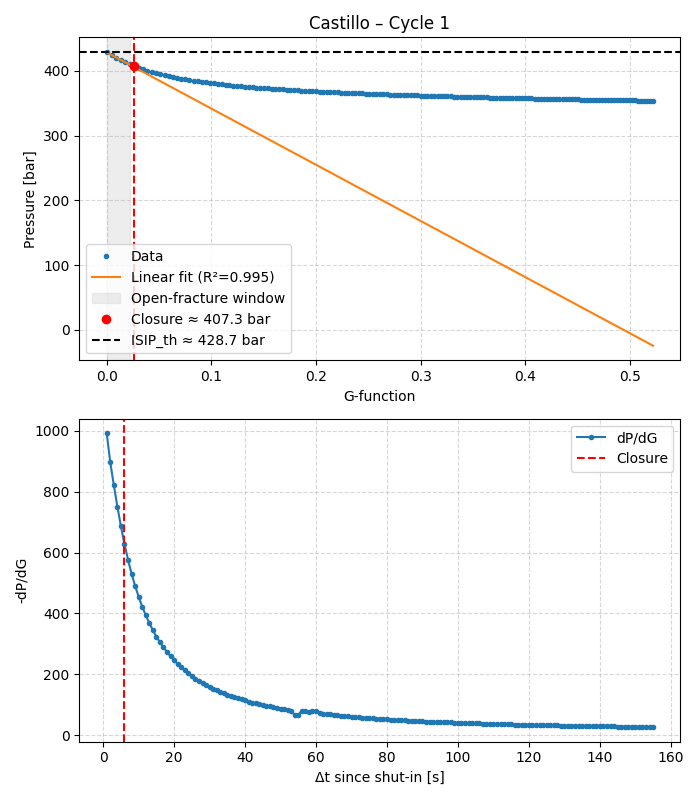

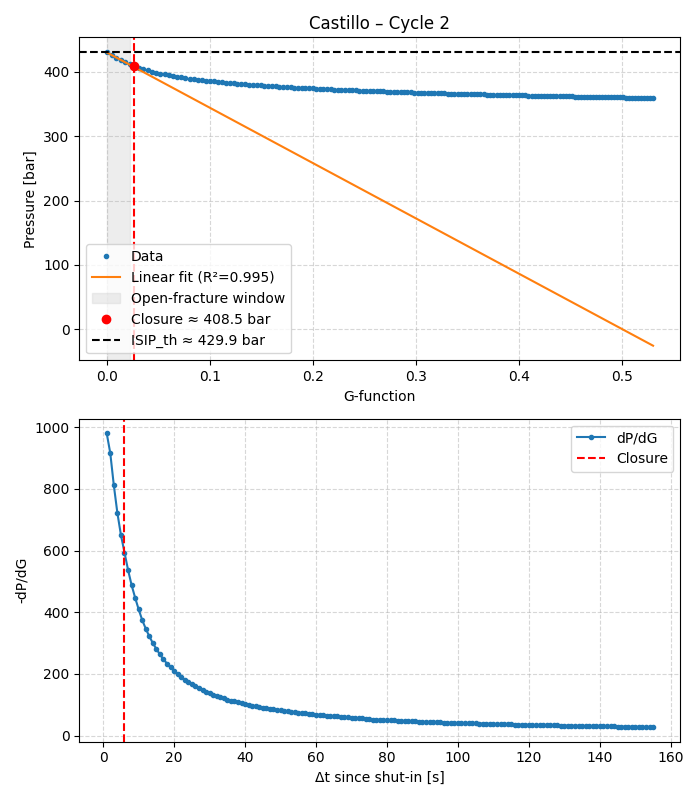

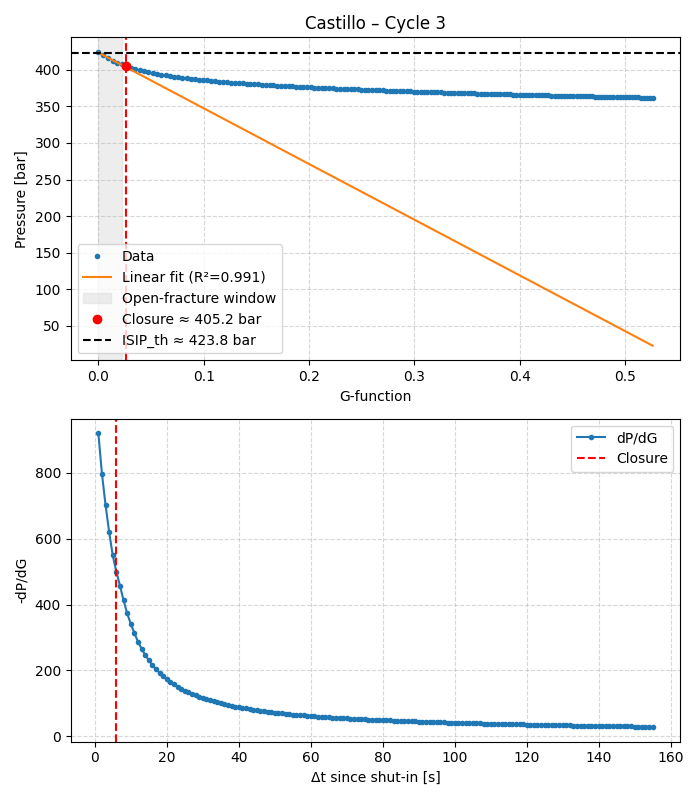

In [212]:
castillo_results = {}

for cyc_id, df in G_cycles.items():
    try:
        res = castillo_analyze_cycle_df(
            df,
            col_t="delta_t_s",
            col_G="G",
            col_P="P_dh_at_frac_bar",
            open_frac_window=(0, 0.05),  # <-- SET YOUR OPEN-FRACTURE WINDOW HERE
            deriv_window=3,               # smoothing for dP/dG
            deriv_tol_rel=0,                # closure sensitivity
            t_min_for_linear=0         # ignore first 5 s after shut-in
        )
    except Exception as e:
        print(f"Cycle {cyc_id}: Castillo analysis failed – {e}")
        print("  Reason:", e)
        continue

    castillo_results[cyc_id] = res
    plot_castillo_cycle(df, res, title=f"Castillo – Cycle {cyc_id}")

    print(f"Cycle {cyc_id}:")
    print(f"  P* (match pressure)          = {res.P_star:.2f} bar")
    print(f"  ISIP_th (G→0)                = {res.P_isip_theoretical:.2f} bar")
    if res.P_closure is not None:
        print(f"  Castillo closure pressure    = {res.P_closure:.2f} bar\n")
    else:
        print("  No closure detected.\n")

## Haimson

In [213]:
import numpy as np

def bilinear_model_anchored(P, m1, m2, P_break, P_anchor, Y_anchor):
    """
    Continuous bilinear model with the LEFT segment anchored at (P_anchor, Y_anchor):

        For P <= P_break:  Y = Y_break + m1 * (P - P_break)
        For P >  P_break:  Y = Y_break + m2 * (P - P_break)

    with Y_break determined by requiring the left segment to pass exactly through
    (P_anchor, Y_anchor):

        Y_anchor = Y_break + m1 * (P_anchor - P_break)
        -> Y_break = Y_anchor - m1 * (P_anchor - P_break)
    """
    P = np.asarray(P, dtype=float)

    Y_break = Y_anchor - m1 * (P_anchor - P_break)

    Y = np.empty_like(P)
    mask_left = P <= P_break
    mask_right = ~mask_left

    Y[mask_left]  = Y_break + m1 * (P[mask_left]  - P_break)
    Y[mask_right] = Y_break + m2 * (P[mask_right] - P_break)

    return Y


def haimson_bilinear_fit_anchored(P, Y, min_seg_size=5, skip_high_n=0, trim_frac=0.3):
    """
    Haimson-style bilinear fit of Y vs P using a discrete breakpoint search,
    with the LOW-PRESSURE segment (left) anchored at the lowest-P datapoint.

    IMPORTANT: For the regressions that determine slopes and breakpoint:

      - Left segment: drops the LAST `trim_frac` of points (the right side of the left segment).
      - Right segment: drops the FIRST `trim_frac` of points (the left side of the right segment).

    This means the breakpoint P_break (FCP) is influenced only by the
    "interior" 70% of each segment, as requested.

    Parameters
    ----------
    P : array-like
        Pressure values.
    Y : array-like
        Y = -dP/dt values.
    min_seg_size : int
        Minimum number of points on each side of the break BEFORE trimming.
    skip_high_n : int
        Number of highest-P points to remove from the fitting data entirely.
    trim_frac : float
        Fraction (0–1) of points to trim at the junctions of each segment.

    Returns
    -------
    dict or None
        Same structure as before:
            {
              "P_sorted", "Y_sorted",
              "m1", "m2", "P_break",
              "P_anchor", "Y_anchor", "Y_break",
              "Y_fit",
              "R2_all", "R2_left", "R2_right",
            }
        or None if the fit cannot be performed.
    """
    P = np.asarray(P, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # drop NaNs/infs
    mask = np.isfinite(P) & np.isfinite(Y)
    P = P[mask]
    Y = Y[mask]
    if P.size == 0:
        return None

    # sort by pressure (ascending)
    sort_idx = np.argsort(P)
    P_sorted_all = P[sort_idx]
    Y_sorted_all = Y[sort_idx]

    # optionally drop the highest-pressure points from the fitting data
    if skip_high_n > 0:
        if P_sorted_all.size <= skip_high_n:
            return None
        P_sorted = P_sorted_all[:-skip_high_n]
        Y_sorted = Y_sorted_all[:-skip_high_n]
    else:
        P_sorted = P_sorted_all
        Y_sorted = Y_sorted_all

    n = P_sorted.size
    if n < 2 * min_seg_size + 2:
        return None

    # anchor point: lowest pressure datapoint (after skipping high points)
    P_anchor = P_sorted[0]
    Y_anchor = Y_sorted[0]

    # indices of possible breakpoints, ensuring at least min_seg_size points
    # on each side BEFORE trimming
    i_min = min_seg_size
    i_max = n - min_seg_size - 1
    if i_min >= i_max:
        return None

    best_sse = np.inf
    best_params = None
    best_i_break = None

    # scan over discrete break indices
    for i_break in range(i_min, i_max + 1):
        P_break = P_sorted[i_break]

        # left: indices 0..i_break  (inclusive)
        P_left = P_sorted[: i_break + 1]
        Y_left = Y_sorted[: i_break + 1]

        # right: indices i_break+1 .. end
        P_right = P_sorted[i_break + 1 :]
        Y_right = Y_sorted[i_break + 1 :]

        if P_left.size < min_seg_size or P_right.size < min_seg_size:
            continue

        # ----- trim segments -----
        def _trim_left(P_seg, Y_seg):
            n_seg = P_seg.size
            if n_seg < 2:
                return None, None
            n_trim = int(trim_frac * n_seg)
            end = max(n_seg - n_trim, 2)  # keep at least 2
            return P_seg[:end], Y_seg[:end]

        def _trim_right(P_seg, Y_seg):
            n_seg = P_seg.size
            if n_seg < 2:
                return None, None
            n_trim = int(trim_frac * n_seg)
            start = min(n_trim, n_seg - 2)  # keep at least 2
            return P_seg[start:], Y_seg[start:]

        P_left_fit, Y_left_fit = _trim_left(P_left, Y_left)
        P_right_fit, Y_right_fit = _trim_right(P_right, Y_right)

        if P_left_fit is None or P_right_fit is None:
            continue
        if P_left_fit.size < 2 or P_right_fit.size < 2:
            continue

        # ----- anchored regression on left: Y = Y_anchor + m1 (P - P_anchor) -----
        Xl = P_left_fit - P_anchor
        Yl = Y_left_fit - Y_anchor
        denom_l = np.sum(Xl**2)
        if denom_l <= 0:
            continue
        m1 = np.sum(Xl * Yl) / denom_l

        # Y_break from anchor condition
        Y_break = Y_anchor - m1 * (P_anchor - P_break)

        # ----- regression on right: Y = Y_break + m2 (P - P_break) -----
        Xr = P_right_fit - P_break
        Yr = Y_right_fit - Y_break
        denom_r = np.sum(Xr**2)
        if denom_r <= 0:
            continue
        m2 = np.sum(Xr * Yr) / denom_r

        # ----- compute SSE on the TRIMMED segments (what drives the breakpoint) -----
        Y_left_pred  = Y_anchor + m1 * (P_left_fit  - P_anchor)
        Y_right_pred = Y_break + m2 * (P_right_fit - P_break)

        sse_left  = np.sum((Y_left_fit  - Y_left_pred) ** 2)
        sse_right = np.sum((Y_right_fit - Y_right_pred) ** 2)
        sse_total = sse_left + sse_right

        if sse_total < best_sse:
            best_sse = sse_total
            best_params = (m1, m2, P_break, Y_break)
            best_i_break = i_break

    if best_params is None:
        return None

    m1, m2, P_break, Y_break = best_params

    # ----- build full-length fit over P_sorted_all -----
    Y_fit_full = bilinear_model_anchored(
        P_sorted_all, m1, m2, P_break, P_anchor, Y_anchor
    )

    # ----- compute R² on TRIMMED portions only (consistent with fit) -----
    # re-create the left/right sets for the winning breakpoint index
    P_left_all = P_sorted[: best_i_break + 1]
    Y_left_all = Y_sorted[: best_i_break + 1]
    P_right_all = P_sorted[best_i_break + 1 :]
    Y_right_all = Y_sorted[best_i_break + 1 :]

    P_left_fit, Y_left_fit = _trim_left(P_left_all, Y_left_all)
    P_right_fit, Y_right_fit = _trim_right(P_right_all, Y_right_all)

    def _R2(P_seg, Y_seg, m, P_break, Y_break, side):
        if P_seg is None or Y_seg is None or P_seg.size < 2:
            return np.nan
        if side == "left":
            Y_pred = Y_anchor + m * (P_seg - P_anchor)
        else:
            Y_pred = Y_break + m * (P_seg - P_break)
        ss_res = np.sum((Y_seg - Y_pred) ** 2)
        ss_tot = np.sum((Y_seg - Y_seg.mean()) ** 2)
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    R2_left = _R2(P_left_fit,  Y_left_fit,  m1, P_break, Y_break, side="left")
    R2_right = _R2(P_right_fit, Y_right_fit, m2, P_break, Y_break, side="right")

    # "overall" R²: use trimmed segments combined
    if P_left_fit is not None and P_right_fit is not None:
        P_all_fit = np.concatenate([P_left_fit, P_right_fit])
        Y_all_fit = np.concatenate([Y_left_fit, Y_right_fit])
        Y_pred_all = np.concatenate([
            Y_anchor + m1 * (P_left_fit - P_anchor),
            Y_break + m2 * (P_right_fit - P_break),
        ])
        ss_res_all = np.sum((Y_all_fit - Y_pred_all) ** 2)
        ss_tot_all = np.sum((Y_all_fit - Y_all_fit.mean()) ** 2)
        R2_all = 1.0 - ss_res_all / ss_tot_all if ss_tot_all > 0 else np.nan
    else:
        R2_all = np.nan

    return {
        "P_sorted": P_sorted_all,   # full sorted P (including skipped highs)
        "Y_sorted": Y_sorted_all,   # full sorted Y
        "m1": m1,
        "m2": m2,
        "P_break": P_break,
        "P_anchor": P_anchor,
        "Y_anchor": Y_anchor,
        "Y_break": Y_break,
        "Y_fit": Y_fit_full,        # fit evaluated over all sorted P
        "R2_all": R2_all,
        "R2_left": R2_left,
        "R2_right": R2_right,
    }

Cycle 1: Ps ≈ 381.64 bar (R²_all=0.999, R²_left=0.956, R²_right=0.996)


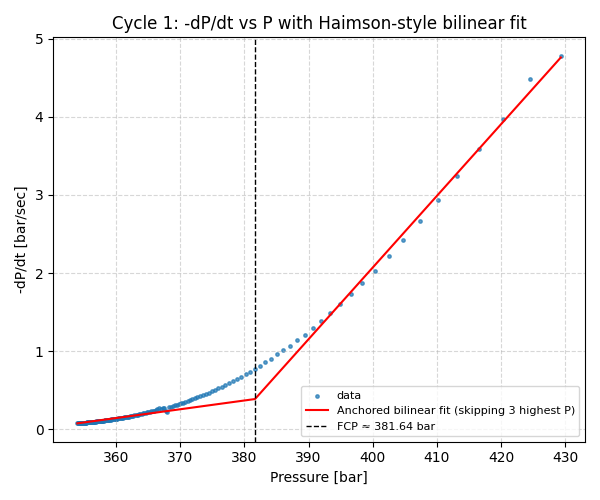

Cycle 2: Ps ≈ 386.82 bar (R²_all=0.998, R²_left=0.959, R²_right=0.992)


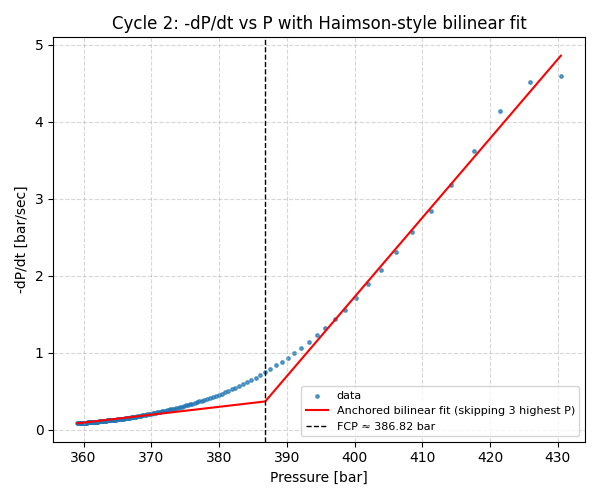

Cycle 3: Ps ≈ 390.81 bar (R²_all=0.999, R²_left=0.983, R²_right=0.993)


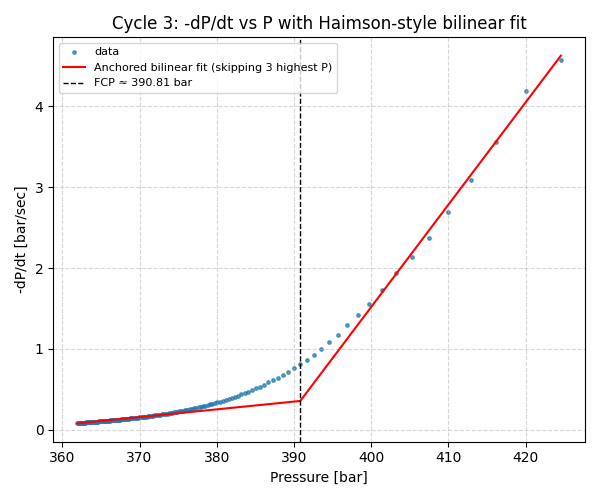

In [214]:
# -------------------------------------------
# Haimson-style plot: dP/dt vs P (normal time, derivative in bar/sec)
#   + NLRA-style continuous bilinear regression in P
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for dP/dt vs P plots.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()     # Δt [sec]
        P    = df["P_dh_at_frac_bar"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P)
        dt_s = dt_s[mask]
        P    = P[mask]

        if dt_s.size < 5:
            print(f"Cycle {cyc_id}: not enough points for dP/dt.")
            continue

        sort_idx_t = np.argsort(dt_s)
        dt_s = dt_s[sort_idx_t]
        P    = P[sort_idx_t]

        dPdt = np.gradient(P, dt_s)
        Y = -dPdt

        fit = haimson_bilinear_fit_anchored(P, Y, min_seg_size=5, skip_high_n=0)

        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(P, Y, marker="o", s=6, alpha=0.7, label="data")

        if fit is not None:
            P_sorted = fit["P_sorted"]   # full sorted P
            Y_fit    = fit["Y_fit"]
            P_break  = fit["P_break"]

            ax.plot(P_sorted, Y_fit, "r-", lw=1.5,
                    label="Anchored bilinear fit (skipping 3 highest P)")
            ax.axvline(P_break, color="k", ls="--", lw=1.0,
                       label=f"FCP ≈ {P_break:.2f} bar")

            print(
                f"Cycle {cyc_id}: Ps ≈ {P_break:.2f} bar "
                f"(R²_all={fit['R2_all']:.3f}, "
                f"R²_left={fit['R2_left']:.3f}, R²_right={fit['R2_right']:.3f})"
            )
        else:
            print(f"Cycle {cyc_id}: anchored bilinear fit failed or insufficient data.")

        ax.set_xlabel("Pressure [bar]")
        ax.set_ylabel("-dP/dt [bar/sec]")
        ax.set_title(f"Cycle {cyc_id}: -dP/dt vs P with Haimson-style bilinear fit")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

## Barree (2009)

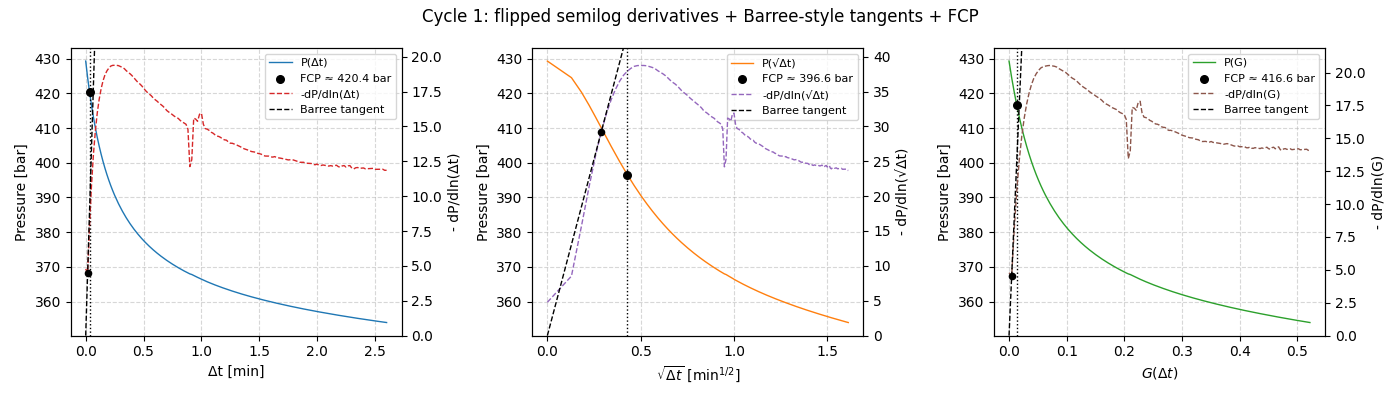

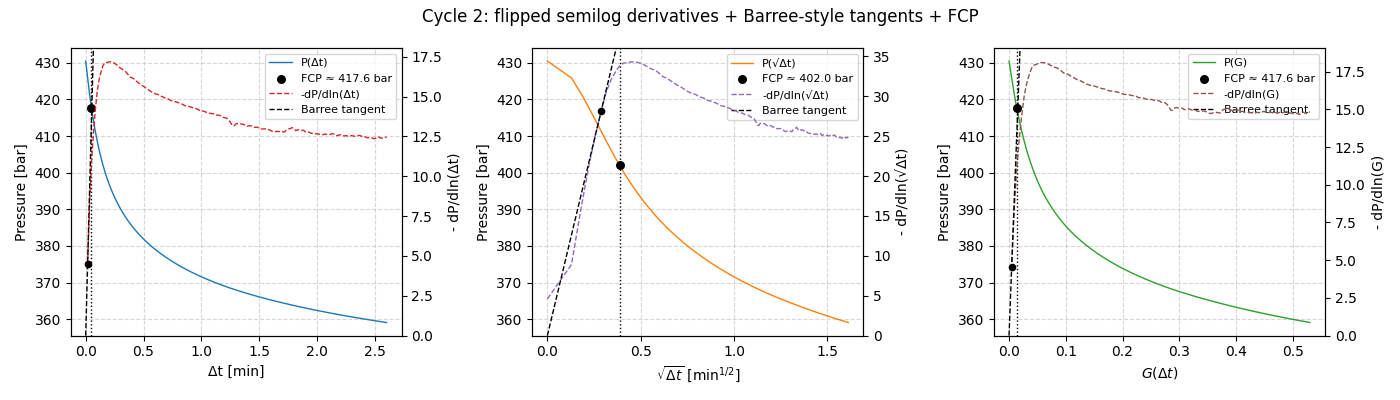

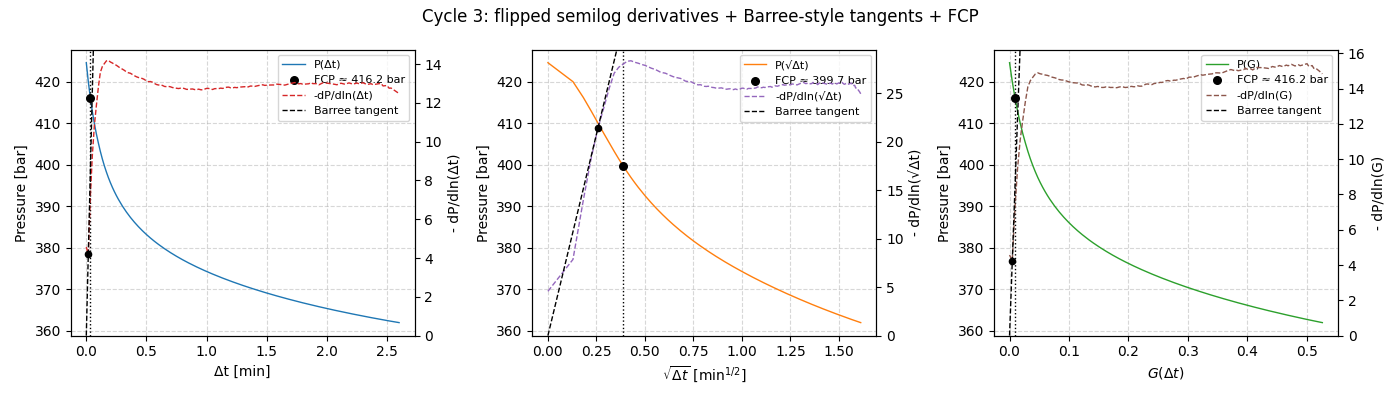

In [215]:
def semilog_derivative(x, P):
    """
    Compute semilog derivative: dP/dln(x) = x * dP/dx.
    Returns:
      x_valid, P_valid, dP_dlogx
    with x >= 0 and finite, including a value at shut-in (x=0).
    """
    x = np.asarray(x, dtype=float)
    P = np.asarray(P, dtype=float)

    # Allow x == 0 so we keep the shut-in point
    mask = np.isfinite(x) & np.isfinite(P) & (x >= 0.0)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    x_valid = x[mask]
    P_valid = P[mask]

    # Numerical derivative dP/dx
    dPdx = np.gradient(P_valid, x_valid)

    # Avoid zero multiplier at shut-in: use next time step as "effective" x
    x_eff = x_valid.copy()
    if x_eff.size > 1 and x_eff[0] == 0.0:
        x_eff[0] = x_eff[1]

    dP_dlogx = x_eff * dPdx

    return x_valid, P_valid, dP_dlogx


def autoscale_semilog_axis(ax, y, lower=2, upper=98, margin=0.15):
    """
    Autoscale a derivative axis by robust percentiles (default 2–98%),
    BUT always ensure that y = 0 is included in the visible axis range.
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return

    # percentile-based scaling
    y_lo = np.percentile(y, lower)
    y_hi = np.percentile(y, upper)

    # padding for comfort
    yr = y_hi - y_lo
    if yr <= 0:
        yr = max(abs(y_lo), abs(y_hi), 1e-6)

    y_lo_new = y_lo - margin * yr
    y_hi_new = y_hi + margin * yr

    # Ensure 0 is ALWAYS visible
    if y_lo_new > 0:
        y_lo_new = 0
    if y_hi_new < 0:
        y_hi_new = 0

    ax.set_ylim(y_lo_new, y_hi_new)


def _barree_tangent_and_fcp(x_arr, d_arr, P_arr, tol_rel=0.1):
    """
    Internal helper:
    - x_arr: x (dt_min, sqrt(dt_min), or G), including x>=0
    - d_arr: flipped semilog derivative, -dP/dln(x)
    - P_arr: pressure aligned with x_arr
    Returns:
      (m, x_touch, y_touch, x_fcp, P_fcp) where:
        m        : slope of tangent from origin
        x_touch  : x where tangent just touches -semilog (before its max)
        y_touch  : -semilog at x_touch
        x_fcp    : x where -semilog deviates from tangent (first point)
        P_fcp    : pressure at that x (FCP on pressure curve)
      Any of these can be None if not found.
    """
    x_bar = np.asarray(x_arr, dtype=float)
    y_bar = np.asarray(d_arr, dtype=float)
    P_bar = np.asarray(P_arr, dtype=float)

    mask_bar = (x_bar > 0.0) & np.isfinite(y_bar) & np.isfinite(P_bar)
    x_bar = x_bar[mask_bar]
    y_bar = y_bar[mask_bar]
    P_bar = P_bar[mask_bar]

    if x_bar.size <= 1:
        return None, None, None, None, None

    # 1) Find index of maximum -semilog value
    idx_max = int(np.nanargmax(y_bar))

    # 2) Restrict to points up to that max
    x_sub = x_bar[: idx_max + 1]
    y_sub = y_bar[: idx_max + 1]
    P_sub = P_bar[: idx_max + 1]

    mask_nz = x_sub > 0.0
    x_sub = x_sub[mask_nz]
    y_sub = y_sub[mask_nz]
    P_sub = P_sub[mask_nz]

    if x_sub.size == 0:
        return None, None, None, None, None

    # 3) Slope of line from origin to each candidate point
    slopes = y_sub / x_sub
    i_best = int(np.nanargmax(slopes))
    m = slopes[i_best]
    x_touch = x_sub[i_best]
    y_touch = y_sub[i_best]

    # 4) Tangent line over the full x-range
    x_line_full = x_bar  # use full domain for FCP detection
    y_tan_full = m * x_line_full

    # identify the index in x_bar that corresponds to x_touch
    # (x_touch came from x_sub, which is a subset of x_bar, so equality is OK)
    idx_touch_candidates = np.where(x_bar == x_touch)[0]
    idx_touch = int(idx_touch_candidates[0]) if idx_touch_candidates.size > 0 else 0

    # 5) FCP: first point AFTER touch where -semilog deviates downward
    # from the tangent by more than tol_rel * |tangent|
    x_fcp, P_fcp = None, None
    for i in range(idx_touch + 1, len(x_bar)):
        yt = y_tan_full[i]
        yd = y_bar[i]
        # skip near-zero tangent to avoid division noise
        if not np.isfinite(yt) or abs(yt) < 1e-9:
            continue
        if (yt - yd) > tol_rel * abs(yt):
            x_fcp = x_bar[i]
            P_fcp = P_bar[i]
            break

    return m, x_touch, y_touch, x_fcp, P_fcp


# -------------------------------------------
# 5) ONE FIGURE PER CYCLE: semilog derivatives (flipped) + Barree-style tangents + FCP
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for semilog derivatives.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points for semilog derivative.")
            continue

        dt_min      = dt_s / 60.0
        sqrt_dt_min = np.sqrt(dt_min)

        # semilog derivatives (including shut-in at x=0 if present)
        x_dt,   P_dt,   dP_dlog_dt    = semilog_derivative(dt_min,      P)
        x_sqrt, P_sqrt, dP_dlog_sqrt  = semilog_derivative(sqrt_dt_min, P)
        x_G,    P_G,    dP_dlog_G     = semilog_derivative(Gval,        P)

        # flipped for plotting
        dP_dlog_dt    = -dP_dlog_dt
        dP_dlog_sqrt  = -dP_dlog_sqrt
        dP_dlog_G     = -dP_dlog_G

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle(f"Cycle {cyc_id}: flipped semilog derivatives + Barree-style tangents + FCP")

        # -------------------------------------------------
        # 1) Δt
        # -------------------------------------------------
        ax1 = axes[0]
        if x_dt.size > 0:
            lineP_dt, = ax1.plot(x_dt, P_dt, color="C0", lw=1.0, label="P(Δt)")
            ax1b = ax1.twinx()
            lineD_dt, = ax1b.plot(x_dt, dP_dlog_dt, color="C3", lw=1.0, ls="--",
                                  label="-dP/dln(Δt)")
            ax1.set_xlabel("Δt [min]")
            ax1.set_ylabel("Pressure [bar]")
            ax1b.set_ylabel("- dP/dln(Δt)")
            ax1.grid(True, linestyle="--", alpha=0.5)

            # Barree-style tangent and FCP
            m_dt, x_touch_dt, y_touch_dt, x_fcp_dt, P_fcp_dt = _barree_tangent_and_fcp(
                x_dt, dP_dlog_dt, P_dt, tol_rel=0.1
            )

            if m_dt is not None:
                # tangent from origin to end of curve
                x_line = np.array([0.0, x_dt.max()])
                y_line = m_dt * x_line
                lineTan_dt, = ax1b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                # touch point on -semilog
                ax1b.scatter([x_touch_dt], [y_touch_dt], color="k", s=20, zorder=5)

                # FCP on pressure curve
                if x_fcp_dt is not None and P_fcp_dt is not None:
                    ax1.axvline(x_fcp_dt, color="k", ls=":", lw=1.0)
                    ax1.scatter([x_fcp_dt], [P_fcp_dt], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_dt:.1f} bar")

            autoscale_semilog_axis(ax1b, dP_dlog_dt)

            # combined legend (pressure + derivative + tangent + FCP)
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax1b.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 2) √Δt
        # -------------------------------------------------
        ax2 = axes[1]
        if x_sqrt.size > 0:
            lineP_sqrt, = ax2.plot(x_sqrt, P_sqrt, color="C1", lw=1.0, label="P(√Δt)")
            ax2b = ax2.twinx()
            lineD_sqrt, = ax2b.plot(x_sqrt, dP_dlog_sqrt, color="C4", lw=1.0, ls="--",
                                    label="-dP/dln(√Δt)")
            ax2.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
            ax2.set_ylabel("Pressure [bar]")
            ax2b.set_ylabel("- dP/dln(√Δt)")
            ax2.grid(True, linestyle="--", alpha=0.5)

            m_sqrt, x_touch_sqrt, y_touch_sqrt, x_fcp_sqrt, P_fcp_sqrt = _barree_tangent_and_fcp(
                x_sqrt, dP_dlog_sqrt, P_sqrt, tol_rel=0.1
            )

            if m_sqrt is not None:
                x_line = np.array([0.0, x_sqrt.max()])
                y_line = m_sqrt * x_line
                lineTan_sqrt, = ax2b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                ax2b.scatter([x_touch_sqrt], [y_touch_sqrt], color="k", s=20, zorder=5)

                if x_fcp_sqrt is not None and P_fcp_sqrt is not None:
                    ax2.axvline(x_fcp_sqrt, color="k", ls=":", lw=1.0)
                    ax2.scatter([x_fcp_sqrt], [P_fcp_sqrt], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_sqrt:.1f} bar")

            autoscale_semilog_axis(ax2b, dP_dlog_sqrt)

            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2b.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 3) G(Δt)
        # -------------------------------------------------
        ax3 = axes[2]
        if x_G.size > 0:
            lineP_G, = ax3.plot(x_G, P_G, color="C2", lw=1.0, label="P(G)")
            ax3b = ax3.twinx()
            lineD_G, = ax3b.plot(x_G, dP_dlog_G, color="C5", lw=1.0, ls="--",
                                 label="-dP/dln(G)")
            ax3.set_xlabel(r"$G(\Delta t)$")
            ax3.set_ylabel("Pressure [bar]")
            ax3b.set_ylabel("- dP/dln(G)")
            ax3.grid(True, linestyle="--", alpha=0.5)

            m_G, x_touch_G, y_touch_G, x_fcp_G, P_fcp_G = _barree_tangent_and_fcp(
                x_G, dP_dlog_G, P_G, tol_rel=0.1
            )

            if m_G is not None:
                x_line = np.array([0.0, x_G.max()])
                y_line = m_G * x_line
                lineTan_G, = ax3b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                ax3b.scatter([x_touch_G], [y_touch_G], color="k", s=20, zorder=5)

                if x_fcp_G is not None and P_fcp_G is not None:
                    ax3.axvline(x_fcp_G, color="k", ls=":", lw=1.0)
                    ax3.scatter([x_fcp_G], [P_fcp_G], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_G:.1f} bar")

            autoscale_semilog_axis(ax3b, dP_dlog_G)

            lines1, labels1 = ax3.get_legend_handles_labels()
            lines2, labels2 = ax3b.get_legend_handles_labels()
            ax3.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

### Semilog maximum

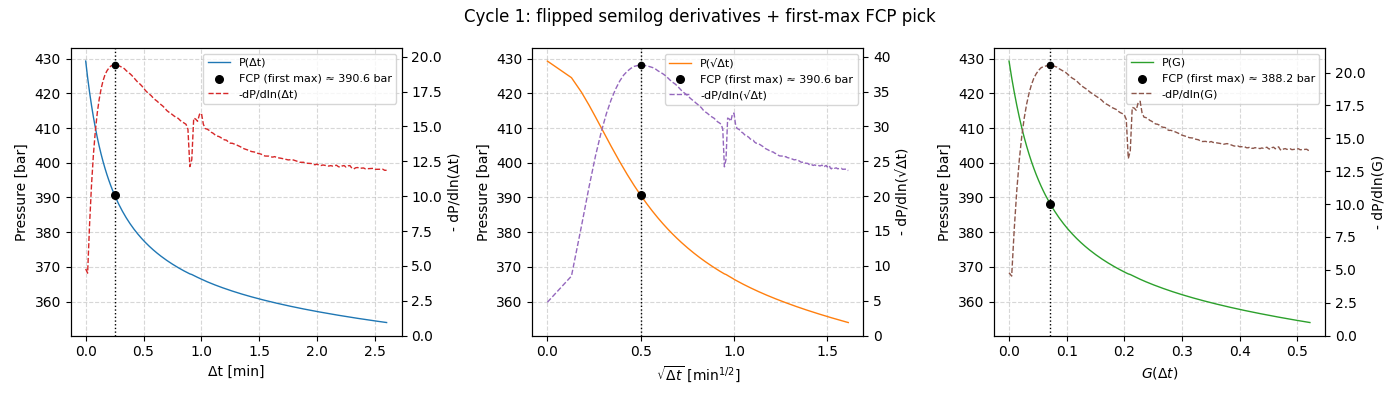

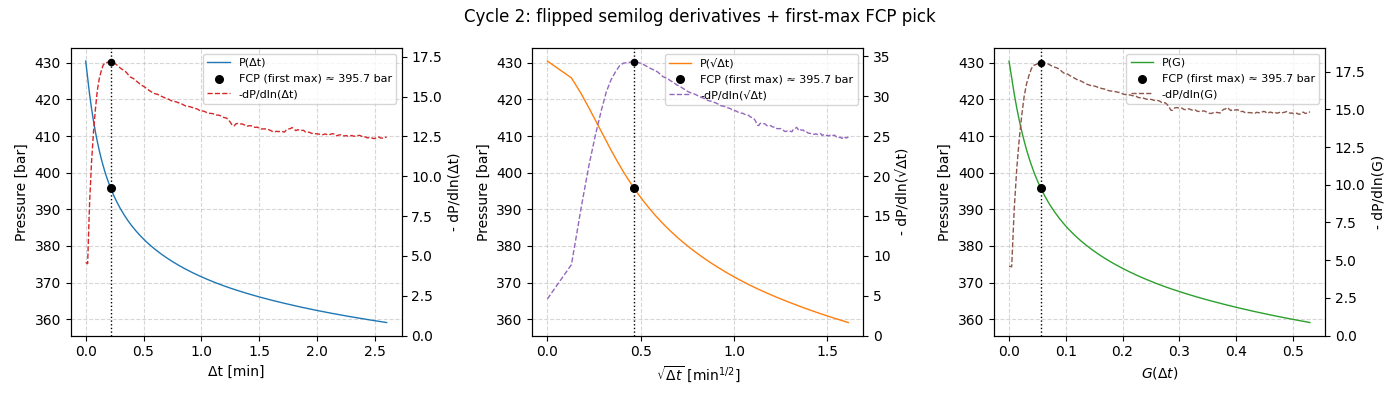

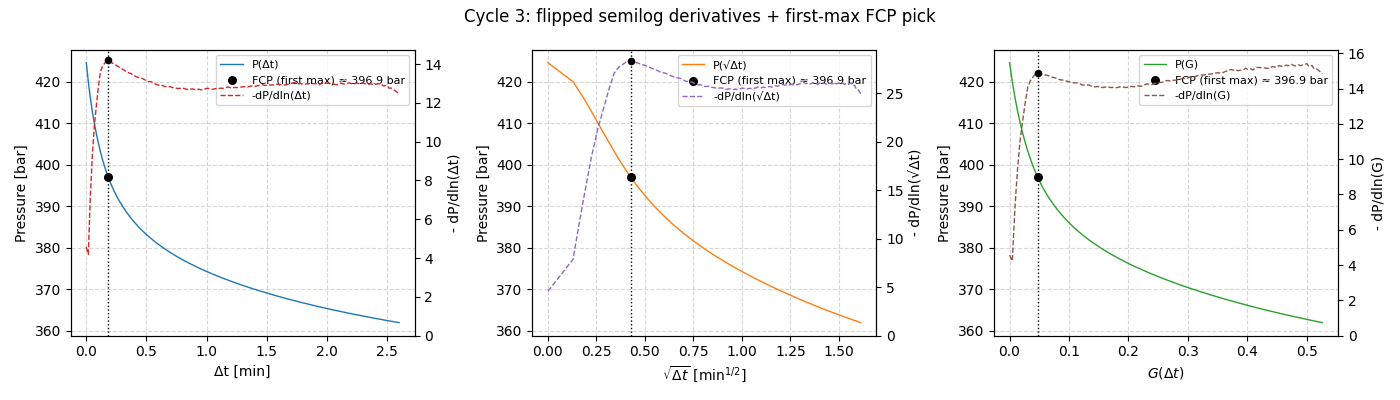

In [216]:
def _first_semilog_max_pick(x_arr, d_arr, P_arr):
    """
    Pick FCP as the FIRST local maximum of the semilog derivative curve.

    Inputs:
      x_arr : x values (dt_min, sqrt(dt_min), or G), including x >= 0
      d_arr : semilog derivative curve we want the max of
              (in your plots this will be the flipped one: -dP/dln(x))
      P_arr : pressure aligned with x_arr

    Returns:
      (x_peak, y_peak, P_peak)
      Any of these can be None if no usable maximum is found.
    """
    x = np.asarray(x_arr, dtype=float)
    y = np.asarray(d_arr, dtype=float)
    P = np.asarray(P_arr, dtype=float)

    mask = (x > 0.0) & np.isfinite(y) & np.isfinite(P)
    x = x[mask]
    y = y[mask]
    P = P[mask]

    if x.size < 3:
        return None, None, None

    # 1) look for first local maximum y[i] >= y[i-1] and y[i] > y[i+1]
    peak_idx = None
    for i in range(1, len(y) - 1):
        if (y[i] >= y[i - 1]) and (y[i] > y[i + 1]):
            peak_idx = i
            break

    # 2) fallback: if no local maximum found, use the global maximum
    if peak_idx is None:
        try:
            peak_idx = int(np.nanargmax(y))
        except ValueError:
            return None, None, None

    x_peak = x[peak_idx]
    y_peak = y[peak_idx]
    P_peak = P[peak_idx]

    return x_peak, y_peak, P_peak


# -------------------------------------------
# NEW: ONE FIGURE PER CYCLE
#      semilog derivatives (flipped) + FIRST MAX FCP
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for semilog derivatives.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points for semilog derivative.")
            continue

        dt_min      = dt_s / 60.0
        sqrt_dt_min = np.sqrt(dt_min)

        # semilog derivatives (including shut-in at x=0 if present)
        x_dt,   P_dt,   dP_dlog_dt    = semilog_derivative(dt_min,      P)
        x_sqrt, P_sqrt, dP_dlog_sqrt  = semilog_derivative(sqrt_dt_min, P)
        x_G,    P_G,    dP_dlog_G     = semilog_derivative(Gval,        P)

        # flipped for plotting (this is what we take maxima of)
        d_dt_plot    = -dP_dlog_dt
        d_sqrt_plot  = -dP_dlog_sqrt
        d_G_plot     = -dP_dlog_G

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle(
            f"Cycle {cyc_id}: flipped semilog derivatives + first-max FCP pick"
        )

        # -------------------------------------------------
        # 1) Δt
        # -------------------------------------------------
        ax1 = axes[0]
        if x_dt.size > 0:
            ax1.plot(x_dt, P_dt, color="C0", lw=1.0, label="P(Δt)")
            ax1b = ax1.twinx()
            ax1b.plot(x_dt, d_dt_plot, color="C3", lw=1.0, ls="--",
                      label="-dP/dln(Δt)")
            ax1.set_xlabel("Δt [min]")
            ax1.set_ylabel("Pressure [bar]")
            ax1b.set_ylabel("- dP/dln(Δt)")
            ax1.grid(True, linestyle="--", alpha=0.5)

            # First maximum of semilog derivative
            x_peak_dt, y_peak_dt, P_peak_dt = _first_semilog_max_pick(
                x_dt, d_dt_plot, P_dt
            )

            if x_peak_dt is not None and P_peak_dt is not None:
                # vertical line & markers
                ax1.axvline(x_peak_dt, color="k", ls=":", lw=1.0)
                ax1.scatter([x_peak_dt], [P_peak_dt], color="k", s=30,
                            zorder=6, label=f"FCP (first max) ≈ {P_peak_dt:.1f} bar")
                ax1b.scatter([x_peak_dt], [y_peak_dt], color="k", s=20, zorder=5)

            autoscale_semilog_axis(ax1b, d_dt_plot)

            # combined legend
            l1, lab1 = ax1.get_legend_handles_labels()
            l2, lab2 = ax1b.get_legend_handles_labels()
            ax1.legend(l1 + l2, lab1 + lab2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 2) √Δt
        # -------------------------------------------------
        ax2 = axes[1]
        if x_sqrt.size > 0:
            ax2.plot(x_sqrt, P_sqrt, color="C1", lw=1.0, label="P(√Δt)")
            ax2b = ax2.twinx()
            ax2b.plot(x_sqrt, d_sqrt_plot, color="C4", lw=1.0, ls="--",
                      label="-dP/dln(√Δt)")
            ax2.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
            ax2.set_ylabel("Pressure [bar]")
            ax2b.set_ylabel("- dP/dln(√Δt)")
            ax2.grid(True, linestyle="--", alpha=0.5)

            x_peak_sqrt, y_peak_sqrt, P_peak_sqrt = _first_semilog_max_pick(
                x_sqrt, d_sqrt_plot, P_sqrt
            )

            if x_peak_sqrt is not None and P_peak_sqrt is not None:
                ax2.axvline(x_peak_sqrt, color="k", ls=":", lw=1.0)
                ax2.scatter([x_peak_sqrt], [P_peak_sqrt], color="k", s=30,
                            zorder=6, label=f"FCP (first max) ≈ {P_peak_sqrt:.1f} bar")
                ax2b.scatter([x_peak_sqrt], [y_peak_sqrt], color="k", s=20, zorder=5)

            autoscale_semilog_axis(ax2b, d_sqrt_plot)

            l1, lab1 = ax2.get_legend_handles_labels()
            l2, lab2 = ax2b.get_legend_handles_labels()
            ax2.legend(l1 + l2, lab1 + lab2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 3) G(Δt)
        # -------------------------------------------------
        ax3 = axes[2]
        if x_G.size > 0:
            ax3.plot(x_G, P_G, color="C2", lw=1.0, label="P(G)")
            ax3b = ax3.twinx()
            ax3b.plot(x_G, d_G_plot, color="C5", lw=1.0, ls="--",
                      label="-dP/dln(G)")
            ax3.set_xlabel(r"$G(\Delta t)$")
            ax3.set_ylabel("Pressure [bar]")
            ax3b.set_ylabel("- dP/dln(G)")
            ax3.grid(True, linestyle="--", alpha=0.5)

            x_peak_G, y_peak_G, P_peak_G = _first_semilog_max_pick(
                x_G, d_G_plot, P_G
            )

            if x_peak_G is not None and P_peak_G is not None:
                ax3.axvline(x_peak_G, color="k", ls=":", lw=1.0)
                ax3.scatter([x_peak_G], [P_peak_G], color="k", s=30,
                            zorder=6, label=f"FCP (first max) ≈ {P_peak_G:.1f} bar")
                ax3b.scatter([x_peak_G], [y_peak_G], color="k", s=20, zorder=5)

            autoscale_semilog_axis(ax3b, d_G_plot)

            l1, lab1 = ax3.get_legend_handles_labels()
            l2, lab2 = ax3b.get_legend_handles_labels()
            ax3.legend(l1 + l2, lab1 + lab2, loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

## System Stiffness

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional


@dataclass
class StiffnessPick:
    idx_min: int
    idx_target: Optional[int]
    dP_dG_min: float
    dP_dG_target: float
    P_at_min: float
    P_at_target: Optional[float]
    G_at_min: float
    G_at_target: Optional[float]
    t_at_min: Optional[float]
    t_at_target: Optional[float]
    dP_dG: np.ndarray


def system_stiffness_pick(
    G: np.ndarray,
    P: np.ndarray,
    t: Optional[np.ndarray] = None,
    smooth: bool = False,
    smooth_window: int = 5,
) -> StiffnessPick:
    """
    System stiffness pick based on the MINIMUM of -dP/dG:
      - compute dP/dG vs G,
      - define D = -dP/dG,
      - find min(D),
      - define target = 1.10 * min(D),
      - find first point AFTER the minimum where D >= target,
      - report pressure at that point (P_at_target).
    """
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    if G.shape != P.shape:
        raise ValueError("G and P must have the same shape.")

    if t is not None:
        t = np.asarray(t, dtype=float)
        if t.shape != G.shape:
            raise ValueError("t must have same shape as G and P.")

    # original derivative
    dP_dG = np.gradient(P, G)

    # apply negative transformation
    neg_dP_dG = -dP_dG

    # Optional smoothing
    if smooth and smooth_window > 1:
        k = smooth_window
        if k % 2 == 0:
            k += 1
        pad = k // 2
        kernel = np.ones(k) / k
        neg_dP_dG = np.convolve(
            np.pad(neg_dP_dG, pad_width=pad, mode="edge"),
            kernel,
            mode="valid"
        )

    # 1) Find minimum of the NEGATIVE derivative
    idx_min = int(np.nanargmin(neg_dP_dG))
    dP_dG_min = float(neg_dP_dG[idx_min])

    # 2) Target = 110% of that minimum
    dP_dG_target = 1.10 * dP_dG_min

    # 3) Find first index AFTER the minimum where neg_dP_dG >= target
    idx_target = None
    for i in range(idx_min + 1, len(neg_dP_dG)):
        if neg_dP_dG[i] >= dP_dG_target:
            idx_target = int(i)
            break

    # 4) Gather results
    P_at_min = float(P[idx_min])
    G_at_min = float(G[idx_min])
    t_at_min = float(t[idx_min]) if t is not None else None

    if idx_target is not None:
        P_at_target = float(P[idx_target])
        G_at_target = float(G[idx_target])
        t_at_target = float(t[idx_target]) if t is not None else None
    else:
        P_at_target = None
        G_at_target = None
        t_at_target = None

    return StiffnessPick(
        idx_min=idx_min,
        idx_target=idx_target,
        dP_dG_min=dP_dG_min,
        dP_dG_target=dP_dG_target,
        P_at_min=P_at_min,
        P_at_target=P_at_target,
        G_at_min=G_at_min,
        G_at_target=G_at_target,
        t_at_min=t_at_min,
        t_at_target=t_at_target,
        dP_dG=neg_dP_dG,   # store the NEGATIVE derivative used for picking
    )

def plot_stiffness_cycle(G, P, t, pick: StiffnessPick, title: str = ""):
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    neg_dP_dG = pick.dP_dG  # now NEGATIVE derivative

    fig, ax1 = plt.subplots()

    # Pressure vs G
    ax1.plot(G, P, label="Pressure", alpha=0.8)
    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")

    # -dP/dG vs G
    ax2 = ax1.twinx()
    ax2.plot(G, neg_dP_dG, "--", label="-dP/dG (used for pick)", alpha=0.8)
    ax2.set_ylabel("-dP/dG")

    # Mark min point
    ax2.plot(pick.G_at_min, pick.dP_dG_min, "ro", label="min -dP/dG")

    # Mark target point
    if pick.idx_target is not None:
        ax2.plot(pick.G_at_target, pick.dP_dG_target, "go", label="110% min")
        ax1.axvline(pick.G_at_target, color="g", linestyle="--", alpha=0.5)
        ax1.axhline(pick.P_at_target, color="g", linestyle=":", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    if title:
        ax1.set_title(title)

    fig.tight_layout()
    return fig

Cycles for stiffness analysis:
Cycle 1: shut=2025-11-01 16:27:46, end=2025-11-01 16:36:47
Cycle 2: shut=2025-11-01 17:32:57, end=2025-11-01 17:41:48
Cycle 3: shut=2025-11-01 18:48:20, end=2025-11-01 18:57:16
Cycle 1:
  min dP/dG at G=0.5221, P=353.94
  110% dP/dG point not found within this cycle.
Cycle 2:
  min dP/dG at G=0.5303, P=359.08
  110% dP/dG point not found within this cycle.
Cycle 3:
  min dP/dG at G=0.5261, P=361.94
  110% dP/dG point not found within this cycle.


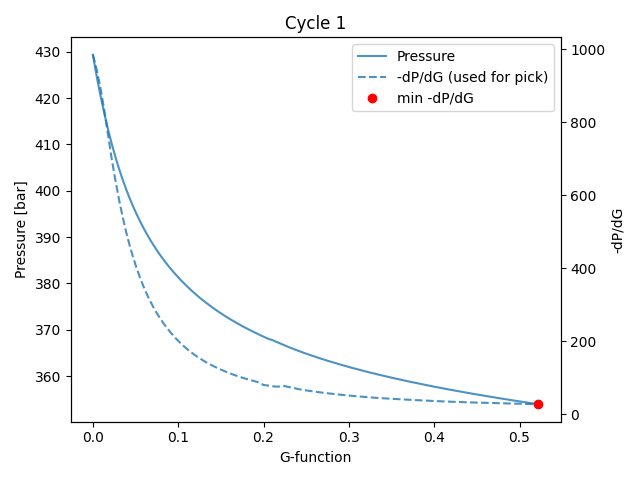

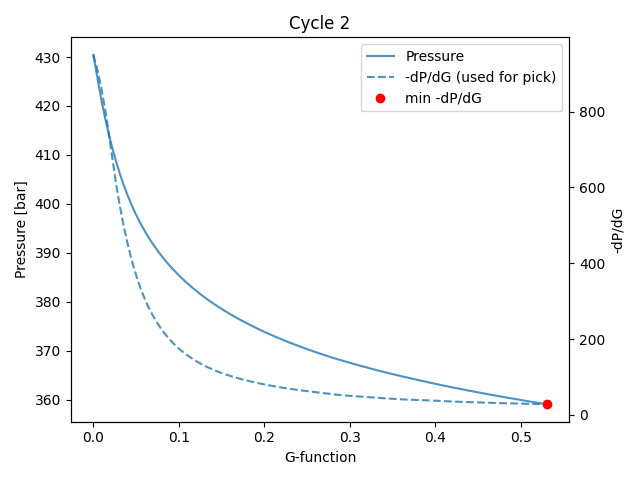

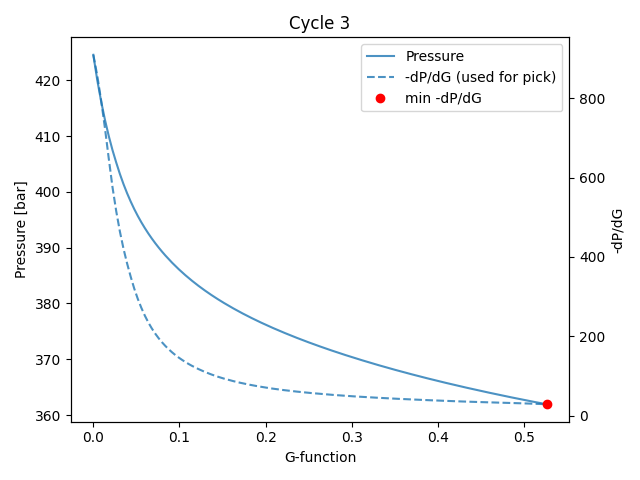

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, List, Dict, Any

# Import picker + result container from your module
from FCP_classes import StiffnessPick, system_stiffness_pick
# or, if your file is FCP_classes_2.py:
# from FCP_classes_2 import StiffnessPick, system_stiffness_pick


def plot_stiffness_cycle(G, P, t, pick: StiffnessPick, title: str = ""):
    """
    Plot pressure vs G and -dP/dG used for the stiffness pick.
    """
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    neg_dP_dG = pick.dP_dG  # NEGATIVE derivative from system_stiffness_pick

    fig, ax1 = plt.subplots()

    # Pressure vs G
    ax1.plot(G, P, label="Pressure", alpha=0.8)
    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")

    # -dP/dG vs G
    ax2 = ax1.twinx()
    ax2.plot(G, neg_dP_dG, "--", label="-dP/dG (used for pick)", alpha=0.8)
    ax2.set_ylabel("-dP/dG")

    # Mark min point
    ax2.plot(pick.G_at_min, pick.dP_dG_min, "ro", label="min -dP/dG")

    # Mark target point
    if pick.idx_target is not None:
        ax2.plot(pick.G_at_target, pick.dP_dG_target, "go", label="110% min")
        ax1.axvline(pick.G_at_target, color="g", linestyle="--", alpha=0.5)
        ax1.axhline(pick.P_at_target, color="g", linestyle=":", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    if title:
        ax1.set_title(title)

    fig.tight_layout()
    return fig


# -------------------------------------------------
# Build `cycles` from your inj_cycles_df dataframe
# -------------------------------------------------

def build_cycles_from_inj_df(inj_cycles_df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Convert an injection cycles DataFrame into a list of dictionaries:

    [
      {"name": "Cycle 1", "t_shut": <Timestamp>, "t_end": <Timestamp>},
      {"name": "Cycle 2", ...},
      ...
    ]

    This is what the system stiffness loop expects (if you need it elsewhere).
    """

    # Try to guess the shut-in time column
    shut_candidates = [
        "t_shut_dh", "t_shut_downhole",
        "t_shut", "t_shut_in_dh"
    ]
    dur_candidates = [
        "falloff_duration_s", "duration_s", "falloff_s", "duration"
    ]

    shut_col = None
    for c in shut_candidates:
        if c in inj_cycles_df.columns:
            shut_col = c
            break
    if shut_col is None:
        raise KeyError(
            f"Could not find shut-in column in inj_cycles_df. "
            f"Tried: {shut_candidates}. Available: {list(inj_cycles_df.columns)}"
        )

    dur_col = None
    for c in dur_candidates:
        if c in inj_cycles_df.columns:
            dur_col = c
            break
    if dur_col is None:
        raise KeyError(
            f"Could not find duration column in inj_cycles_df. "
            f"Tried: {dur_candidates}. Available: {list(inj_cycles_df.columns)}"
        )

    cycles: List[Dict[str, Any]] = []
    for i, row in inj_cycles_df.iterrows():
        # Shut-in time (downhole clock)
        t_shut = row[shut_col]

        # End of falloff = shut-in + duration (seconds)
        t_end = t_shut + pd.to_timedelta(row[dur_col], unit="s")

        # Name: use 'cycle' column if present, else index
        if "cycle" in inj_cycles_df.columns:
            cyc_name = f"Cycle {int(row['cycle'])}"
        else:
            cyc_name = f"Cycle {i+1}"

        cycles.append({
            "name": cyc_name,
            "t_shut": t_shut,
            "t_end": t_end,
        })

    return cycles


# Only needed if you use `cycles` elsewhere; the stiffness loop below uses G_cycles directly.
cycles = build_cycles_from_inj_df(inj_cycles_df)
print("Cycles for stiffness analysis:")
for c in cycles:
    print(f"{c['name']}: shut={c['t_shut']}, end={c['t_end']}")


# -------------------------------------------------
# System stiffness loop over G_cycles
# -------------------------------------------------

results = []

for cyc_id, df in G_cycles.items():
    t_cyc = df["delta_t_s"].to_numpy()          # time since shut-in [s]
    G_cyc = df["G"].to_numpy()
    P_cyc = df["P_dh_at_frac_bar"].to_numpy()

    if len(G_cyc) < 10:
        print(f"Cycle {cyc_id}: too few points, skipping.")
        continue

    pick = system_stiffness_pick(
        G_cyc,
        P_cyc,
        t=t_cyc,
        smooth=True,
        smooth_window=7,
    )
    results.append((cyc_id, pick))

    fig = plot_stiffness_cycle(G_cyc, P_cyc, t_cyc, pick, title=f"Cycle {cyc_id}")

    print(f"Cycle {cyc_id}:")
    print(f"  min dP/dG at G={pick.G_at_min:.4g}, P={pick.P_at_min:.2f}")
    if pick.idx_target is not None:
        print(f"  110% dP/dG at G={pick.G_at_target:.4g}, P={pick.P_at_target:.2f}")
    else:
        print("  110% dP/dG point not found within this cycle.")

## Synthesis

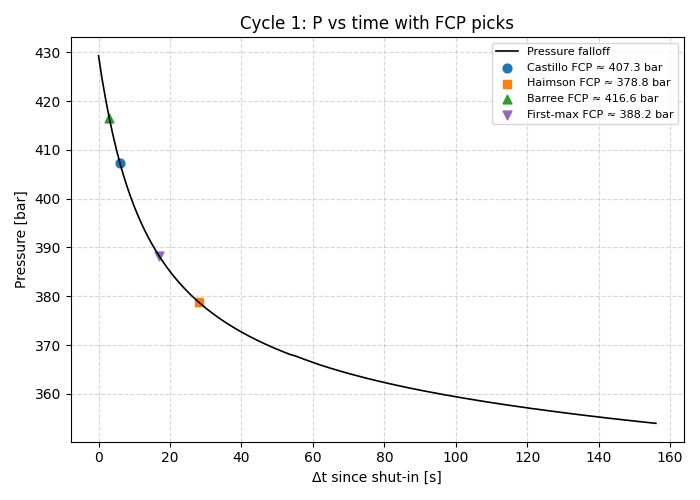

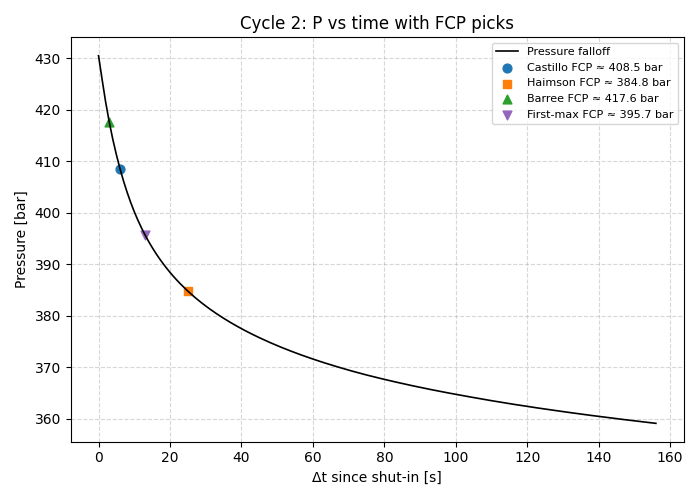

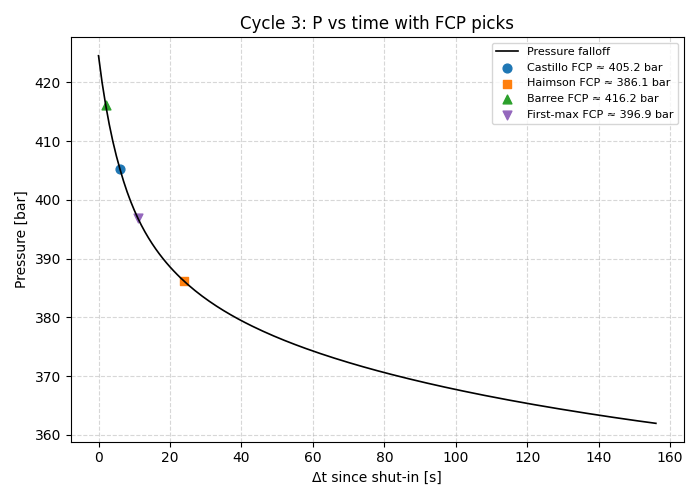

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

from FCP_classes import (
    HaimsonBilinearPicker,
    castillo_analyze_cycle_df,
    system_stiffness_pick,
)

# ---------- helper: semilog derivative in x ----------
def semilog_derivative(x, P):
    """
    Compute semilog derivative: dP/dln(x) = x * dP/dx.
    Returns x_valid, P_valid, dP_dlogx, keeping x >= 0 (incl. shut-in).
    """
    x = np.asarray(x, dtype=float)
    P = np.asarray(P, dtype=float)

    mask = np.isfinite(x) & np.isfinite(P) & (x >= 0.0)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    x_valid = x[mask]
    P_valid = P[mask]

    dPdx = np.gradient(P_valid, x_valid)

    # avoid zero multiplier at shut-in
    x_eff = x_valid.copy()
    if x_eff.size > 1 and x_eff[0] == 0.0:
        x_eff[0] = x_eff[1]

    dP_dlogx = x_eff * dPdx
    return x_valid, P_valid, dP_dlogx


# ---------- helper: Barree-style tangent + FCP on given x, derivative ----------
def _barree_tangent_and_fcp_same_arrays(
    x: np.ndarray,
    d: np.ndarray,
    P: np.ndarray,
    tol_rel: float = 0.1,
):
    """
    Barree-style FCP:
    - x: independent variable (e.g. G)
    - d: -dP/dln(x) (already flipped)
    - P: pressure aligned with x

    Returns (x_touch, m, idx_fcp, x_fcp, P_fcp).
    """
    x = np.asarray(x, float)
    d = np.asarray(d, float)
    P = np.asarray(P, float)

    mask = (x > 0.0) & np.isfinite(d) & np.isfinite(P)
    x_bar = x[mask]
    d_bar = d[mask]
    P_bar = P[mask]

    if x_bar.size <= 1:
        return None, None, None, None, None

    # 1) find index of maximum -semilog
    idx_max = int(np.nanargmax(d_bar))

    x_sub = x_bar[: idx_max + 1]
    d_sub = d_bar[: idx_max + 1]

    mask_nz = x_sub > 0.0
    x_sub = x_sub[mask_nz]
    d_sub = d_sub[mask_nz]

    if x_sub.size == 0:
        return None, None, None, None, None

    slopes = d_sub / x_sub
    i_best = int(np.nanargmax(slopes))
    m = slopes[i_best]
    x_touch = x_sub[i_best]

    # 2) tangent over full x_bar
    d_tan = m * x_bar

    # locate touch index in x_bar
    idx_touch_candidates = np.where(x_bar == x_touch)[0]
    if idx_touch_candidates.size == 0:
        idx_touch = 0
    else:
        idx_touch = int(idx_touch_candidates[0])

    # 3) FCP: first point after touch where d < (1 - tol_rel) * tangent
    idx_fcp = None
    for i in range(idx_touch + 1, len(x_bar)):
        yt = d_tan[i]
        yd = d_bar[i]
        if not np.isfinite(yt) or abs(yt) < 1e-9:
            continue
        if yd < (1.0 - tol_rel) * yt:
            idx_fcp = i
            break

    if idx_fcp is None:
        return x_touch, m, None, None, None

    x_fcp = x_bar[idx_fcp]
    P_fcp = P_bar[idx_fcp]
    return x_touch, m, idx_fcp, x_fcp, P_fcp


# ---------- helper: first-maximum semilog FCP ----------
def first_semilog_max_pick(x_arr, d_arr, P_arr):
    """
    Pick FCP as the FIRST local maximum of the semilog derivative curve.

    Inputs:
      x_arr : x values (e.g. G), x >= 0
      d_arr : flipped semilog derivative (e.g. -dP/dln(G))
      P_arr : pressure aligned with x_arr

    Returns:
      (x_peak, P_peak, idx_peak)
    """
    x = np.asarray(x_arr, dtype=float)
    y = np.asarray(d_arr, dtype=float)
    P = np.asarray(P_arr, dtype=float)

    mask = (x > 0.0) & np.isfinite(y) & np.isfinite(P)
    x = x[mask]
    y = y[mask]
    P = P[mask]

    if x.size < 3:
        return None, None, None

    # 1) First local maximum
    peak_idx = None
    for i in range(1, len(y) - 1):
        if y[i] >= y[i - 1] and y[i] > y[i + 1]:
            peak_idx = i
            break

    # 2) Fallback: global maximum
    if peak_idx is None:
        try:
            peak_idx = int(np.nanargmax(y))
        except Exception:
            return None, None, None

    return x[peak_idx], P[peak_idx], peak_idx


# ---------- main: per-cycle FCP analysis + store picks ----------
haimson_picker = HaimsonBilinearPicker(min_seg_size=5, skip_high_n=3)

FCP_PICKS = {}  # <- global container for synthesis

for cyc_id, df in sorted(G_cycles.items()):
    # basic arrays
    t_s = df["delta_t_s"].to_numpy()          # [s] since shut-in
    Gval = df["G"].to_numpy()
    P    = df["P_dh_at_frac_bar"].to_numpy()

    # mask finite
    mask = np.isfinite(t_s) & np.isfinite(Gval) & np.isfinite(P)
    t_s  = t_s[mask]
    Gval = Gval[mask]
    P    = P[mask]

    if t_s.size < 5:
        print(f"Cycle {cyc_id}: not enough points for combined FCP plot, skipping.")
        FCP_PICKS[cyc_id] = {
            "castillo": (None, None),
            "haimson":  (None, None),
            "barree":   (None, None),
            "stiff":    (None, None),
            "first_max": (None, None),
        }
        continue

    # -------------------------
    # 1) Castillo FCP (G-function)
    # -------------------------
    t_fcp_cast, P_fcp_cast = None, None
    try:
        # rebuild a masked df explicitly:
        df_masked = df.loc[mask] if len(df) == len(mask) else df.iloc[mask.nonzero()[0]]

        res_cast = castillo_analyze_cycle_df(
            df_masked,
            col_t="delta_t_s",
            col_G="G",
            col_P="P_dh_at_frac_bar",
            open_frac_window=(0.0, 0.05),
            deriv_window=7,
            deriv_tol_rel=0.0,
            t_min_for_linear=0.0,
        )
        if res_cast.idx_closure is not None:
            t_fcp_cast = res_cast.t_s[res_cast.idx_closure]
            P_fcp_cast = res_cast.P_closure
    except Exception as e:
        print(f"Cycle {cyc_id}: Castillo failed ({e}), skipping Castillo FCP.")

    # -------------------------
    # 2) Haimson FCP (bilinear -dP/dt vs P)
    # -------------------------
    t_fcp_haim, P_fcp_haim = None, None
    sort_idx_t = np.argsort(t_s)
    t_sorted = t_s[sort_idx_t]
    P_sorted = P[sort_idx_t]

    dPdt = np.gradient(P_sorted, t_sorted)
    Y = -dPdt  # Haimson uses -dP/dt

    res_haim = haimson_picker.fit_PY(P_sorted, Y)
    if res_haim is not None:
        Ps = res_haim.P_break
        idx_closest = int(np.nanargmin(np.abs(P_sorted - Ps)))
        t_fcp_haim = t_sorted[idx_closest]
        P_fcp_haim = P_sorted[idx_closest]

    # -------------------------
    # 3) Barree FCP (G-based semilog)
    # -------------------------
    t_fcp_bar, P_fcp_bar = None, None

    x_G, P_G, dP_dlog_G = semilog_derivative(Gval, P)
    dP_dlog_G_flip = -dP_dlog_G  # Barree style

    if x_G.size > 5:
        x_touch_G, m_G, idx_fcp_G, x_fcp_G, P_fcp_bar_tmp = _barree_tangent_and_fcp_same_arrays(
            x_G, dP_dlog_G_flip, P_G, tol_rel=0.1
        )
        if x_fcp_G is not None:
            idx_time_bar = int(np.nanargmin(np.abs(Gval - x_fcp_G)))
            t_fcp_bar = t_s[idx_time_bar]
            P_fcp_bar = P_fcp_bar_tmp

    # -------------------------
    # 4) System stiffness FCP
    # -------------------------
    t_fcp_stiff, P_fcp_stiff = None, None
    try:
        pick_stiff = system_stiffness_pick(
            Gval, P, t=t_s, smooth=True, smooth_window=7
        )
        t_fcp_stiff = pick_stiff.t_at_target
        P_fcp_stiff = pick_stiff.P_at_target
    except Exception as e:
        print(f"Cycle {cyc_id}: stiffness pick failed ({e})")

    # -------------------------
    # 5) First-max semilog FCP (G-based)
    # -------------------------
    t_fcp_first, P_fcp_first = None, None
    if x_G.size > 5:
        x_peak_G, P_peak_G, idx_peak_G = first_semilog_max_pick(
            x_G, dP_dlog_G_flip, P_G
        )
        if x_peak_G is not None:
            idx_time_first = int(np.nanargmin(np.abs(Gval - x_peak_G)))
            t_fcp_first = t_s[idx_time_first]
            P_fcp_first = P_peak_G

    # -------------------------
    # store picks for synthesis
    # -------------------------
    FCP_PICKS[cyc_id] = {
        "castillo": (t_fcp_cast,  P_fcp_cast),
        "haimson":  (t_fcp_haim,  P_fcp_haim),
        "barree":   (t_fcp_bar,   P_fcp_bar),
        "stiff":    (t_fcp_stiff, P_fcp_stiff),
        "first_max": (t_fcp_first, P_fcp_first),
    }

    # Optional per-cycle plot
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(t_s, P, "k-", lw=1.2, label="Pressure falloff")

    if t_fcp_cast is not None and P_fcp_cast is not None:
        ax.scatter(t_fcp_cast, P_fcp_cast, color="C0", s=40, marker="o",
                   label=f"Castillo FCP ≈ {P_fcp_cast:.1f} bar")
    if t_fcp_haim is not None and P_fcp_haim is not None:
        ax.scatter(t_fcp_haim, P_fcp_haim, color="C1", s=40, marker="s",
                   label=f"Haimson FCP ≈ {P_fcp_haim:.1f} bar")
    if t_fcp_bar is not None and P_fcp_bar is not None:
        ax.scatter(t_fcp_bar, P_fcp_bar, color="C2", s=40, marker="^",
                   label=f"Barree FCP ≈ {P_fcp_bar:.1f} bar")
    if t_fcp_stiff is not None and P_fcp_stiff is not None:
        ax.scatter(t_fcp_stiff, P_fcp_stiff, color="C3", s=40, marker="D",
                   label=f"Stiffness FCP ≈ {P_fcp_stiff:.1f} bar")
    if t_fcp_first is not None and P_fcp_first is not None:
        ax.scatter(t_fcp_first, P_fcp_first, color="C4", s=40, marker="v",
                   label=f"First-max FCP ≈ {P_fcp_first:.1f} bar")

    ax.set_xlabel("Δt since shut-in [s]")
    ax.set_ylabel("Pressure [bar]")
    ax.set_title(f"Cycle {cyc_id}: P vs time with FCP picks")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

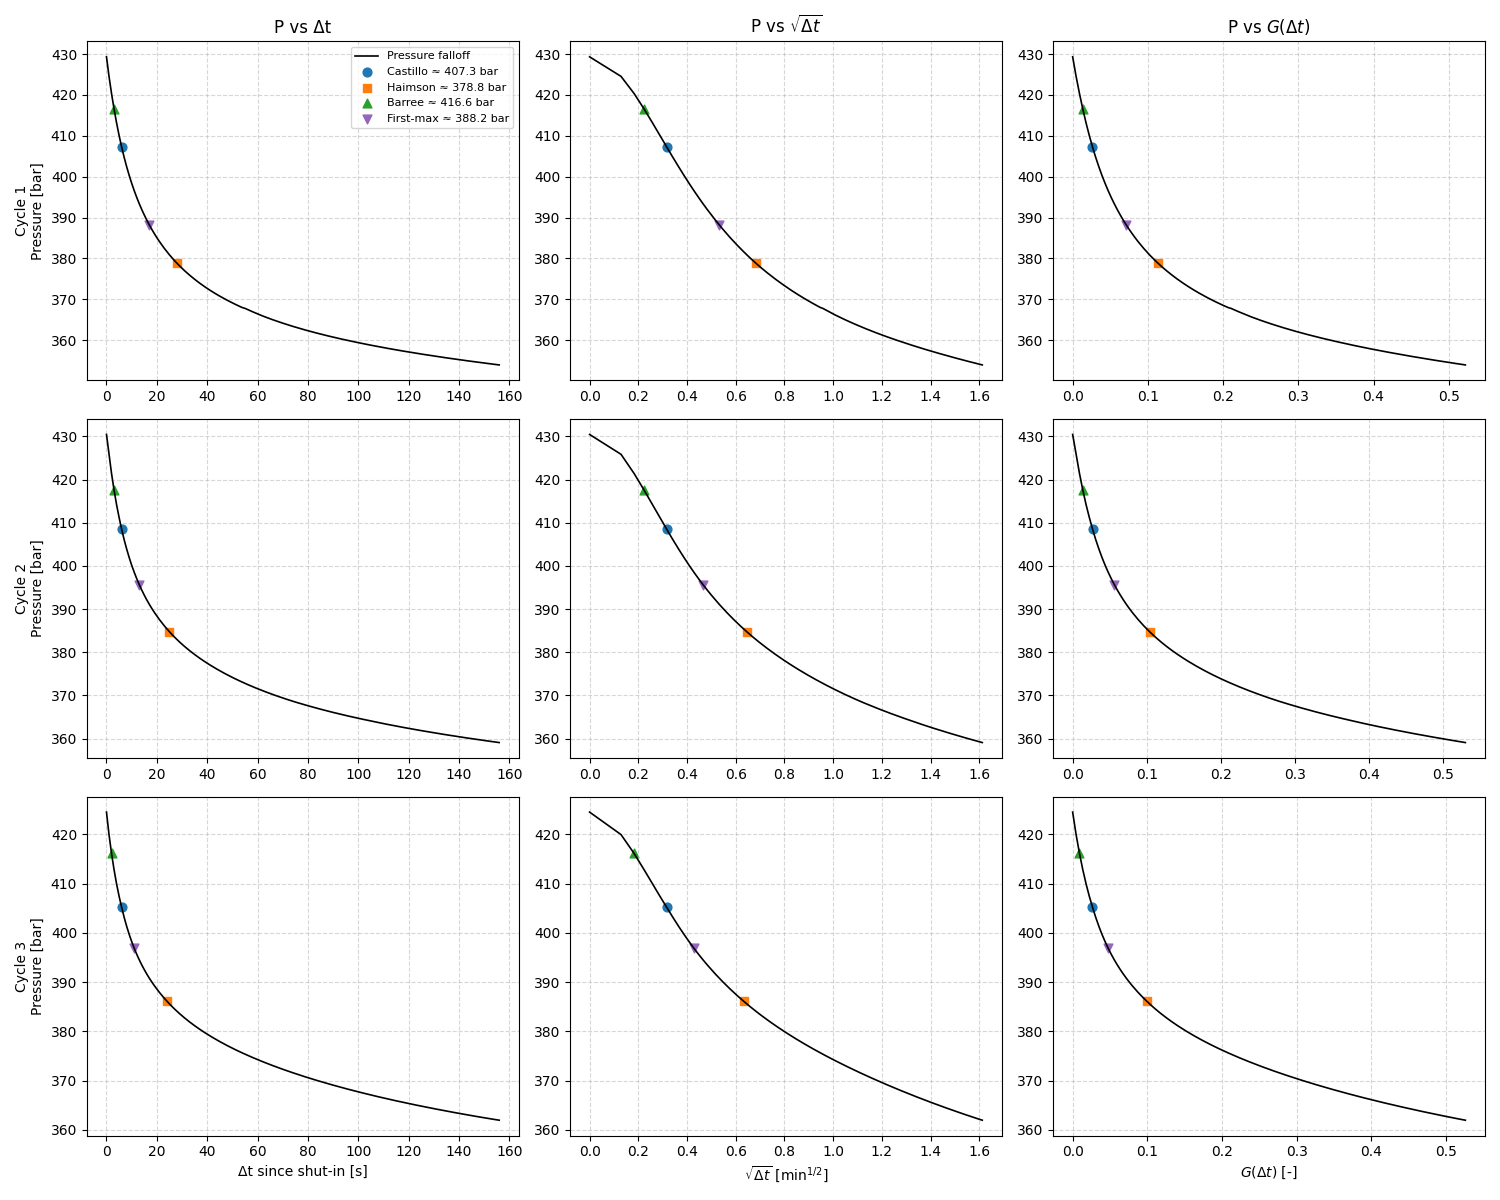


========== FCP SUMMARY TABLE (+ averages & consensus window) ==========



Castillo_t_s  Castillo_P_bar  Haimson_t_s  Haimson_P_bar  Barree_t_s  \
Cycle                                                                         
1               6.0         407.307         28.0        378.817         3.0   
2               6.0         408.548         25.0        384.751         3.0   
3               6.0         405.250         24.0        386.126         2.0   

       Barree_P_bar Stiff_t_s Stiff_P_bar  FirstMax_t_s  FirstMax_P_bar  ...  \
Cycle                                                                    ...   
1           416.588      None        None          17.0         388.214  ...   
2           417.595      None        None          13.0         395.690  ...   
3           416.169      None        None          11.0         396.899  ...   

       Mode_t_s  Mean_P_bar  Median_P_bar  Mode_P_bar  Min_t_s  Max_t_s  \
Cycle                                                                     
1           6.0     397.731       397.760     407.307      3.0     28.0   
2           6.0     401.646       402.119     408.548      3.0     25.0   
3           6.0     401.111       401.074     405.250      2.0     24.0   

       Range_t_s  Min_P_bar  Max_P_bar  Range_P_bar  
Cycle                                                
1           25.0    378.817    416.588       37.771  
2           22.0    384.751    417.595       32.844  
3           22.0    386.126    416.169       30.043  

[3 rows x 22 columns]

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from statistics import mode, StatisticsError
import pandas as pd

# ============================
# Synthesis: 3x3 panel
# rows  = cycles (up to 3)
# cols  = Δt, √Δt, G(Δt)
# ============================

# Choose which cycles to show (first 3 in sorted order)
all_cyc_ids = sorted(G_cycles.keys())
if not all_cyc_ids:
    raise RuntimeError("No cycles in G_cycles for synthesis plotting.")

cyc_ids_plot = all_cyc_ids[:3]
n_rows = len(cyc_ids_plot)
n_cols = 3  # Δt, √Δt, G

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(15, 4 * n_rows),
    squeeze=False,   # always 2D array
)

def _map_time_to_sqrt_t(t_fcp_s: Optional[float]) -> Optional[float]:
    if t_fcp_s is None:
        return None
    return np.sqrt(t_fcp_s / 60.0)  # sqrt(Δt_min)

def _map_time_to_G(t_s: np.ndarray, Gval: np.ndarray, t_fcp_s: Optional[float]) -> Optional[float]:
    if t_fcp_s is None:
        return None
    idx = int(np.nanargmin(np.abs(t_s - t_fcp_s)))
    return Gval[idx]


for row_idx, cyc_id in enumerate(cyc_ids_plot):
    ax_dt   = axes[row_idx, 0]  # Δt
    ax_sqrt = axes[row_idx, 1]  # √Δt
    ax_G    = axes[row_idx, 2]  # G

    df = G_cycles[cyc_id]

    # basic arrays
    t_s  = df["delta_t_s"].to_numpy()          # [s] since shut-in
    Gval = df["G"].to_numpy()
    P    = df["P_dh_at_frac_bar"].to_numpy()

    mask = np.isfinite(t_s) & np.isfinite(Gval) & np.isfinite(P)
    t_s  = t_s[mask]
    Gval = Gval[mask]
    P    = P[mask]

    if t_s.size < 5:
        print(f"Cycle {cyc_id}: not enough points for synthesis plots, skipping row.")
        continue

    dt_min      = t_s / 60.0
    sqrt_dt_min = np.sqrt(dt_min)

    # ---- fetch precomputed picks ----
    picks = FCP_PICKS.get(cyc_id, {})

    t_fcp_cast,  P_fcp_cast   = picks.get("castillo",  (None, None))
    t_fcp_haim,  P_fcp_haim   = picks.get("haimson",   (None, None))
    t_fcp_bar,   P_fcp_bar    = picks.get("barree",    (None, None))
    t_fcp_stiff, P_fcp_stiff  = picks.get("stiff",     (None, None))
    t_fcp_first, P_fcp_first  = picks.get("first_max", (None, None))

    # transformed x positions for √t and G
    sqrt_cast   = _map_time_to_sqrt_t(t_fcp_cast)
    sqrt_haim   = _map_time_to_sqrt_t(t_fcp_haim)
    sqrt_bar    = _map_time_to_sqrt_t(t_fcp_bar)
    sqrt_stiff  = _map_time_to_sqrt_t(t_fcp_stiff)
    sqrt_first  = _map_time_to_sqrt_t(t_fcp_first)

    G_cast   = _map_time_to_G(t_s, Gval, t_fcp_cast)
    G_haim   = _map_time_to_G(t_s, Gval, t_fcp_haim)
    G_bar    = _map_time_to_G(t_s, Gval, t_fcp_bar)
    G_stiff  = _map_time_to_G(t_s, Gval, t_fcp_stiff)
    G_first  = _map_time_to_G(t_s, Gval, t_fcp_first)

    # =========================================
    # Column 1: P vs Δt
    # =========================================
    ax_dt.plot(t_s, P, "k-", lw=1.2, label="Pressure falloff")

    if t_fcp_cast is not None and P_fcp_cast is not None:
        ax_dt.scatter(t_fcp_cast, P_fcp_cast, color="C0", s=40, marker="o",
                      label=f"Castillo ≈ {P_fcp_cast:.1f} bar")
    if t_fcp_haim is not None and P_fcp_haim is not None:
        ax_dt.scatter(t_fcp_haim, P_fcp_haim, color="C1", s=40, marker="s",
                      label=f"Haimson ≈ {P_fcp_haim:.1f} bar")
    if t_fcp_bar is not None and P_fcp_bar is not None:
        ax_dt.scatter(t_fcp_bar, P_fcp_bar, color="C2", s=40, marker="^",
                      label=f"Barree ≈ {P_fcp_bar:.1f} bar")
    if t_fcp_stiff is not None and P_fcp_stiff is not None:
        ax_dt.scatter(t_fcp_stiff, P_fcp_stiff, color="C3", s=40, marker="D",
                      label=f"Stiffness ≈ {P_fcp_stiff:.1f} bar")
    if t_fcp_first is not None and P_fcp_first is not None:
        ax_dt.scatter(t_fcp_first, P_fcp_first, color="C4", s=40, marker="v",
                      label=f"First-max ≈ {P_fcp_first:.1f} bar")

    if row_idx == n_rows - 1:
        ax_dt.set_xlabel("Δt since shut-in [s]")
    if row_idx == 0:
        ax_dt.setTitle = ax_dt.set_title("P vs Δt")

    ax_dt.set_ylabel(f"Cycle {cyc_id}\nPressure [bar]")
    ax_dt.grid(True, linestyle="--", alpha=0.5)

    # only put legend in top-left subplot to avoid clutter
    if row_idx == 0:
        ax_dt.legend(loc="best", fontsize=8)

    # =========================================
    # Column 2: P vs √Δt
    # =========================================
    ax_sqrt.plot(sqrt_dt_min, P, "k-", lw=1.2)

    if sqrt_cast is not None and P_fcp_cast is not None:
        ax_sqrt.scatter(sqrt_cast, P_fcp_cast, color="C0", s=40, marker="o")
    if sqrt_haim is not None and P_fcp_haim is not None:
        ax_sqrt.scatter(sqrt_haim, P_fcp_haim, color="C1", s=40, marker="s")
    if sqrt_bar is not None and P_fcp_bar is not None:
        ax_sqrt.scatter(sqrt_bar, P_fcp_bar, color="C2", s=40, marker="^")
    if sqrt_stiff is not None and P_fcp_stiff is not None:
        ax_sqrt.scatter(sqrt_stiff, P_fcp_stiff, color="C3", s=40, marker="D")
    if sqrt_first is not None and P_fcp_first is not None:
        ax_sqrt.scatter(sqrt_first, P_fcp_first, color="C4", s=40, marker="v")

    if row_idx == n_rows - 1:
        ax_sqrt.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
    if row_idx == 0:
        ax_sqrt.set_title(r"P vs $\sqrt{\Delta t}$")

    ax_sqrt.grid(True, linestyle="--", alpha=0.5)

    # =========================================
    # Column 3: P vs G(Δt)
    # =========================================
    ax_G.plot(Gval, P, "k-", lw=1.2)

    if G_cast is not None and P_fcp_cast is not None:
        ax_G.scatter(G_cast, P_fcp_cast, color="C0", s=40, marker="o")
    if G_haim is not None and P_fcp_haim is not None:
        ax_G.scatter(G_haim, P_fcp_haim, color="C1", s=40, marker="s")
    if G_bar is not None and P_fcp_bar is not None:
        ax_G.scatter(G_bar, P_fcp_bar, color="C2", s=40, marker="^")
    if G_stiff is not None and P_fcp_stiff is not None:
        ax_G.scatter(G_stiff, P_fcp_stiff, color="C3", s=40, marker="D")
    if G_first is not None and P_fcp_first is not None:
        ax_G.scatter(G_first, P_fcp_first, color="C4", s=40, marker="v")

    if row_idx == n_rows - 1:
        ax_G.set_xlabel(r"$G(\Delta t)$ [-]")
    if row_idx == 0:
        ax_G.set_title(r"P vs $G(\Delta t)$")

    ax_G.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# ===============================================
# SUMMARY TABLE OF ALL FCP PICKS
# ===============================================

rows = []

for cyc_id in sorted(FCP_PICKS.keys()):
    picks = FCP_PICKS[cyc_id]

    # Extract picks
    t_cast,   P_cast   = picks.get("castillo",  (None, None))
    t_haim,   P_haim   = picks.get("haimson",   (None, None))
    t_bar,    P_bar    = picks.get("barree",    (None, None))
    t_stiff,  P_stiff  = picks.get("stiff",     (None, None))
    t_first,  P_first  = picks.get("first_max", (None, None))

    # Gather all *valid* times & pressures (including first_max)
    t_valid = [x for x in [t_cast, t_haim, t_bar, t_stiff, t_first] if x is not None]
    P_valid = [x for x in [P_cast, P_haim, P_bar, P_stiff, P_first] if x is not None]

    # ---- Method Averages ----
    if len(t_valid) > 0:
        t_mean   = float(np.mean(t_valid))
        t_median = float(np.median(t_valid))
        try:
            t_mode = mode(t_valid)
        except StatisticsError:
            t_mode = None  # no unique mode

        P_mean   = float(np.mean(P_valid)) if P_valid else None
        P_median = float(np.median(P_valid)) if P_valid else None
        try:
            P_mode = mode(P_valid)
        except StatisticsError:
            P_mode = None
    else:
        t_mean = t_median = t_mode = None
        P_mean = P_median = P_mode = None

    # ---- Consensus window (min, max, range) ----
    if len(t_valid) >= 1:
        t_min = float(np.min(t_valid))
        t_max = float(np.max(t_valid))
        t_range = t_max - t_min
    else:
        t_min = t_max = t_range = None

    if len(P_valid) >= 1:
        P_min = float(np.min(P_valid))
        P_max = float(np.max(P_valid))
        P_range = P_max - P_min
    else:
        P_min = P_max = P_range = None

    rows.append({
        "Cycle": cyc_id,

        "Castillo_t_s": t_cast,
        "Castillo_P_bar": P_cast,

        "Haimson_t_s": t_haim,
        "Haimson_P_bar": P_haim,

        "Barree_t_s": t_bar,
        "Barree_P_bar": P_bar,

        "Stiff_t_s": t_stiff,
        "Stiff_P_bar": P_stiff,

        "FirstMax_t_s": t_first,
        "FirstMax_P_bar": P_first,

        # Method averages
        "Mean_t_s": t_mean,
        "Median_t_s": t_median,
        "Mode_t_s": t_mode,

        "Mean_P_bar": P_mean,
        "Median_P_bar": P_median,
        "Mode_P_bar": P_mode,

        # Consensus window
        "Min_t_s": t_min,
        "Max_t_s": t_max,
        "Range_t_s": t_range,

        "Min_P_bar": P_min,
        "Max_P_bar": P_max,
        "Range_P_bar": P_range,
    })

df_summary = pd.DataFrame(rows)
df_summary = df_summary.set_index("Cycle")
df_summary = df_summary.round(3)

print("\n========== FCP SUMMARY TABLE (+ averages & consensus window) ==========\n")
display(df_summary)

# Save results

In [221]:
from typing import Dict, Tuple, Optional
import numpy as np
import pandas as pd

def build_fcp_summary_df(
    fcp_picks: Dict[int, Dict[str, Tuple[Optional[float], Optional[float]]]],
    well_id: str,
    xlot_microfrac_id: str,
    compliance_m3_per_bar: Optional[Dict[int, float]] = None,
    compliance_L_per_bar: Optional[Dict[int, float]] = None,
) -> pd.DataFrame:
    """
    Build a summary table of FCP picks and compliance per cycle.

    Columns (in order):
        Well_ID, XLOT_Microfrac_ID, Cycle, <per-method time/pressure>, compliance...

    Parameters
    ----------
    fcp_picks : dict
        {
          cycle_id: {
             "castillo": (t_s, P_bar),
             "haimson":  (t_s, P_bar),
             "barree":   (t_s, P_bar),
             "stiff":    (t_s, P_bar),
             "first_max":(t_s, P_bar),  # optional
          },
          ...
        }

    well_id : str
        Well identifier (e.g. "AMS-01", "GT-02").

    xlot_microfrac_id : str
        Test identifier (e.g. "XLOT3_Ieper", "MICROFRAC_2506_7M").

    compliance_m3_per_bar : dict, optional
        {cycle_id: C_m3_per_bar}

    compliance_L_per_bar : dict, optional
        {cycle_id: C_L_per_bar}

    Returns
    -------
    df : pd.DataFrame
        Columns: Well_ID, XLOT_Microfrac_ID, Cycle, <method cols>, compliance cols.
    """
    if not fcp_picks:
        raise ValueError("fcp_picks is empty – nothing to summarise.")

    # infer list of methods from first cycle
    first_methods = list(next(iter(fcp_picks.values())).keys())
    methods = sorted(first_methods)

    rows = []
    for cyc_id in sorted(fcp_picks.keys()):
        picks = fcp_picks[cyc_id]

        row = {
            "Well_ID": well_id,
            "XLOT_Microfrac_ID": xlot_microfrac_id,
            "Cycle": cyc_id,
        }

        # Compliance (if provided)
        if compliance_m3_per_bar is not None:
            row["Compliance_m3_per_bar"] = compliance_m3_per_bar.get(cyc_id, None)
        if compliance_L_per_bar is not None:
            row["Compliance_L_per_bar"] = compliance_L_per_bar.get(cyc_id, None)

        # Per-method closure picks
        for m in methods:
            t_s, P_bar = picks.get(m, (None, None))

            row[f"{m}_t_s"]   = t_s
            row[f"{m}_t_min"] = t_s / 60.0 if t_s is not None else None
            row[f"{m}_P_bar"] = P_bar

        rows.append(row)

    df = pd.DataFrame(rows)

    # Ensure the leading column order explicitly
    # (in case pandas reorders dict keys in any weird way)
    lead_cols = ["Well_ID", "XLOT_Microfrac_ID", "Cycle"]
    other_cols = [c for c in df.columns if c not in lead_cols]
    df = df[lead_cols + other_cols]

    return df

In [222]:
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, Optional

EXCEL_FILENAME = "Test_analysis_results.xlsx"


def save_xlot_results_to_excel(
    fcp_picks: Dict[int, Dict[str, Tuple[Optional[float], Optional[float]]]],
    well_id: str,
    xlot_microfrac_id: str,
    out_dir: Path | str = ".",
    compliance_m3_per_bar: Optional[Dict[int, float]] = None,
    compliance_L_per_bar: Optional[Dict[int, float]] = None,
) -> Path:
    """
    Save FCP results + compliance for all cycles of one XLOT/Microfrac test
    into a unified Excel sheet named 'Test_analysis_results.xlsx'.

    If the file exists, results are appended below existing rows.
    """

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Build summary dataframe
    df_new = build_fcp_summary_df(
        fcp_picks=fcp_picks,
        well_id=well_id,
        xlot_microfrac_id=xlot_microfrac_id,
        compliance_m3_per_bar=compliance_m3_per_bar,
        compliance_L_per_bar=compliance_L_per_bar,
    ).round(3)

    out_path = out_dir / EXCEL_FILENAME

    # --------------------------------------
    # Case 1: File does NOT exist → create it
    # --------------------------------------
    if not out_path.exists():
        with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
            df_new.to_excel(writer, sheet_name="FCP_summary", index=False)
        print(f"Created new Excel file: {out_path}")
        return out_path

    # --------------------------------------
    # Case 2: File exists → append rows
    # --------------------------------------
    try:
        df_existing = pd.read_excel(out_path, sheet_name="FCP_summary")
    except:
        # If sheet missing or corrupt → treat as empty
        df_existing = pd.DataFrame()

    # Append new rows
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)

    # Save back
    with pd.ExcelWriter(out_path, engine="openpyxl", mode="w") as writer:
        df_combined.to_excel(writer, sheet_name="FCP_summary", index=False)

    print(f"Appended results to: {out_path}")
    return out_path

In [223]:
# Example single compliance for all cycles

compliance_m3_per_bar = {cyc_id: C_m3_per_bar for cyc_id in FCP_PICKS.keys()}
compliance_L_per_bar  = {cyc_id: C_L_per_bar  for cyc_id in FCP_PICKS.keys()}

save_xlot_results_to_excel(
    fcp_picks=FCP_PICKS,
    well_id="Delft-01",
    xlot_microfrac_id="XLOT4",
    compliance_m3_per_bar=compliance_m3_per_bar,
    compliance_L_per_bar=compliance_L_per_bar,
)

Appended results to: Test_analysis_results.xlsx


PosixPath('Test_analysis_results.xlsx')

Overlay all pressure buildups. Maybe have a look at h function?